# TopoCluster Regression Model Comparison Between DNN and MDN

Here, we are going to write out our topo-cluster regression notebook. Let's start with charged pions, and see what we can do to understand them.

## Setup and Load Data

In [ ]:
loadModel = True # if false, then run trainings directly. otherwise load the file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install atlas_mpl_style
!pip install uproot3

In [ ]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

path_prefix = '/content/drive/MyDrive/EPE/ML4Pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [ ]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

/usr/local/lib/python3.7/dist-packages/atlas_mpl_style/__init__.py:188: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  "No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False"
/usr/local/lib/python3.7/dist-packages/atlas_mpl_style/__init__.py:188: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  "No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False"


In [ ]:
# import pi+

path = '/content/drive/Shareddrives/UWEPEML/ML4Pion/v7/'
pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pp_tree.pandas.df(branches, flatten=False)
#unused: 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'runNumber', 'eventNumber', 

print("Number of pi+ events: {}".format(len(pp)))

Number of pi+ events: 435967


In [ ]:
#define convenience columns

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT

In [ ]:
# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

In [ ]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))


In [ ]:
# fun cleaning for EMProb
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [ ]:
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)

In [ ]:
scaler_EM = StandardScaler()
pp['s_logEM'] = scaler_EM.fit_transform(pp.cluster_logEM.to_numpy().reshape(-1,1))

In [ ]:
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))

In [ ]:
pp['logCenter'] = np.log(pp.cluster_CENTER_MAG)
scaler_center = StandardScaler()
pp['s_logCenter'] = scaler_center.fit_transform(pp.logCenter.to_numpy().reshape(-1,1))

In [ ]:
scaler_density = StandardScaler()
pp['s_Density'] = scaler_density.fit_transform(pp.cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [ ]:
# define convience sub-frames

pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster
mu.splitFrameTVT(pp, trainfrac = 0.7)          # define a train/test fraction of 70/20% (10% for val at this point)

In [ ]:
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [ ]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

Edits to methods in resolution util; defined here for convenience and quick iterative testing.

In [ ]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu


def _q16(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 16)

def _q84(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 84)

def responsePlot(x, y, figfile='', statistic='median',
                 xlabel='True Energy [GeV]', ylabel='Predicted Energy / True Energy',
                 xlim=(0.3,1000), ylim=(0,3), baseline=True,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    xbin = [10**exp for exp in np.arange(-1.0, 3.1, 0.1)]
    ybin = np.arange(0., 3.1, 0.1)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    
    responseMed = stats.binned_statistic(x, y, bins=xbin, statistic=statistic).statistic
    responseQ16 = stats.binned_statistic(x, y, bins=xbin, statistic=_q16).statistic
    responseQ84 = stats.binned_statistic(x, y, bins=xbin, statistic=_q84).statistic

    responseQ16 = responseMed - responseQ16
    responseQ84 = responseQ84 - responseMed

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1)
    plt.errorbar(xcenter, responseMed, yerr=[responseQ16,responseQ84], color='red')
    if baseline:
        plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black')
    plt.xscale('log')
    plt.ylim(ylim)
    plt.xlim(xlim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)
    # ampl.set_zlabel('Clusters')
    cb = plt.colorbar()
    cb.ax.set_ylabel('Clusters')
    # plt.legend()

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, responseMed


def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))


def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution


def histogramSlices(x, ylist, labels=[''], xstep=0.2, statistic='iqr', title = 'Response',
                 xlabel='Predicted Energy / True Energy', ylabel='Clusters', alpha=1.,
                 xlim=(0.3,1000.), ylim=(0.,3.1), binsize=0.05, baseline=False, logscale=False, density=False,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    
    if type(ylist) != type([]):
        ylist = [ylist]

    xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    last_xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    
    ybin = np.arange(ylim[0], ylim[1], binsize)

    plt.cla()
    plt.clf()

    for xbin_left,xbin_right in zip(last_xbin,xbin[1:]):
        fig = plt.figure()
        val_mask = np.logical_and(x > xbin_left, x < xbin_right)

        for y,label in zip(ylist,labels):
            if statistic == 'iqr':
                med = np.median(y[val_mask])
                iqr = np.percentile(y[val_mask], q=84) - np.percentile(y[val_mask], q=16)
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Median = {:.2f}, IQR = {:.2f}'.format(med, iqr),
                         alpha=alpha)
            elif statistic == 'std':
                mu = np.mean(y[val_mask])
                sig = np.std(y[val_mask])
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Mean = {:.2f}, Std. Dev. = {:.2f}'.format(mu, sig),
                         alpha=alpha)
            else:
                plt.hist(y[val_mask], bins=ybin, density=density,
                         label = label,
                         alpha=alpha)
            
            if baseline:
                x1 = np.linspace(-6,6,100)
                pdf = stats.norm.pdf(x1)
                plt.plot(x1, pdf, label='Unit Normal')

        if len(textlist) >= 2:
            textlist[1]['text'] = '{:.4g} - {:.4g} GeV Clusters'.format(xbin_left, xbin_right)
            pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

        if logscale:
            plt.yscale('log')

        # plt.title(title + ' {:.4g} - {:.4g} GeV'.format(xbin_left, xbin_right))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(ylim)
        plt.legend()
        plt.show()


# Model Evaluation

## DNN

In [ ]:
def DNN():
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    # create model
    if True:
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=1, activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse', metrics=['mae','mse'])
    return model

In [ ]:
regressor_All = KerasRegressor(build_fn=DNN, batch_size=200, epochs=100, verbose=1)
print(DNN().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
if loadModel:
    regressor_All.model = load_model(modelpath + 'dnn_regressor.h5')
else:
    chkpoint = tf.keras.callbacks.ModelCheckpoint('./dnn_regressor.h5', monitor='loss', verbose=1, save_best_only=True)
    # earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, verbose=0, restore_best_weights=True)
    history_baseline_all = regressor_All.fit(All_input[pp.train], 
                                             pp[pp.train].s_logECalib.to_numpy(),
                                            #  validation_split=0.1,
                                             callbacks=[chkpoint])

### Results

In [ ]:
pred = regressor_All.predict(All_input)
pp['predict_regressor_DNN'] = np.exp(scaler_cal.inverse_transform(pred))
pp['predict_regressor_DNN_EoverCalib'] = pp.predict_regressor_DNN / pp.cluster_ENG_CALIB_TOT

2180/2180 [==============================] - 4s 1ms/step


#### Residual

No handles with labels found to put in legend.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


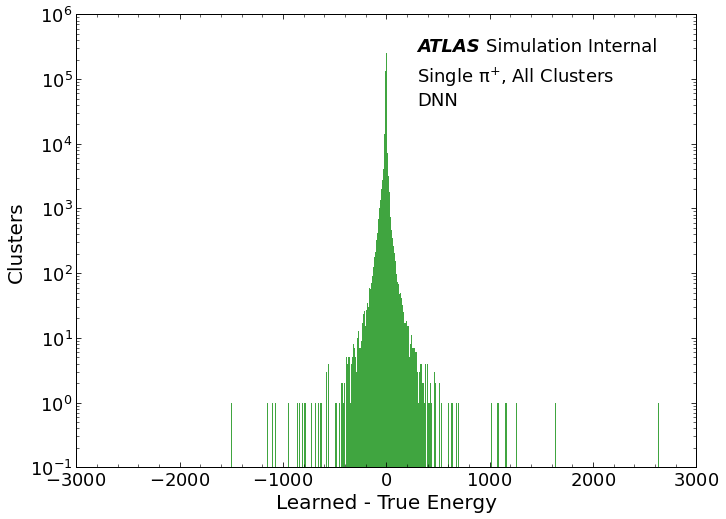

In [ ]:
resid_DNN = pp.predict_regressor_DNN-pp.cluster_ENG_CALIB_TOT

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.75)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.ylabel('Clusters')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'DNN'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

#### Response

<Figure size 799.992x599.976 with 0 Axes>

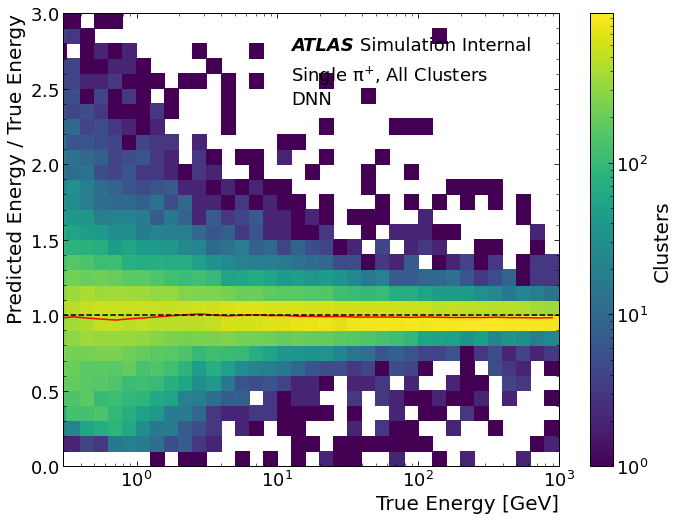

In [ ]:
xcenter, medDNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'DNN'}])

In [ ]:
# _, _ = responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
#                  plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
#                  'median',
#                  atlas_x = 0.46, atlas_y = 0.95, simulation = True,
#                  textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
#                              {'x': 0.46, 'y': 0.8,  'text': 'DNN'}])

#### Response Histogram Slices

<Figure size 799.992x599.976 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


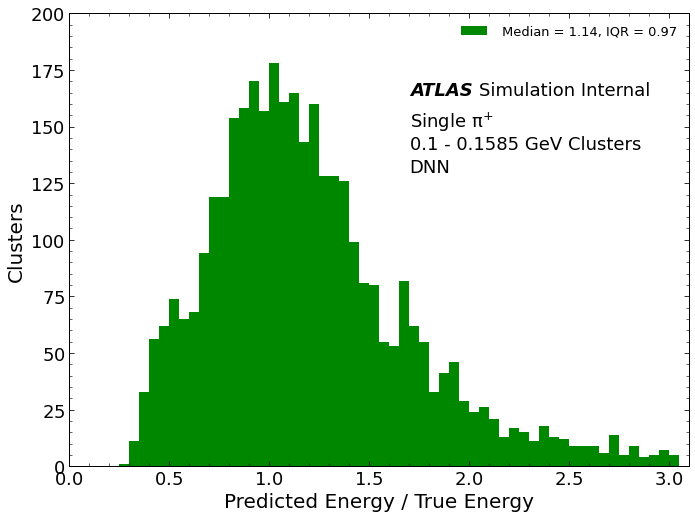

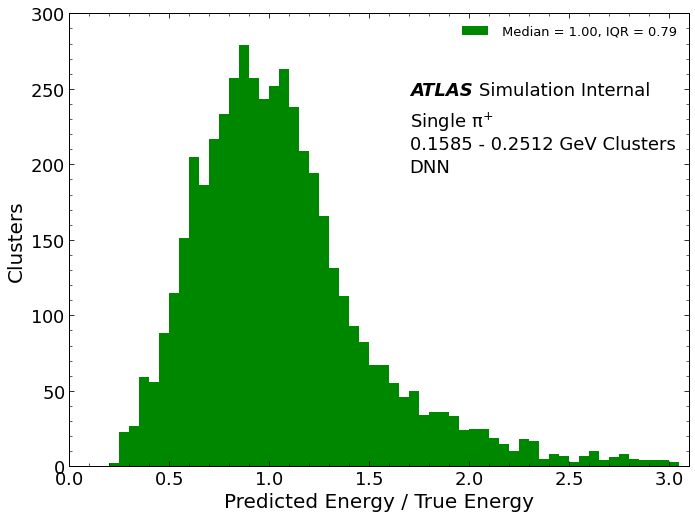

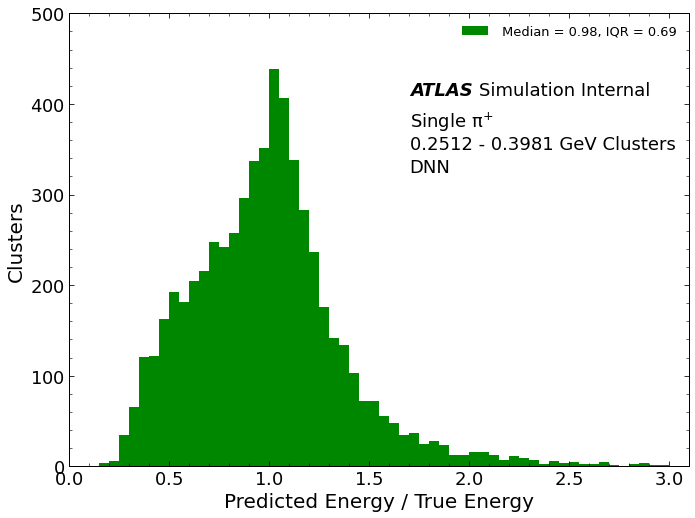

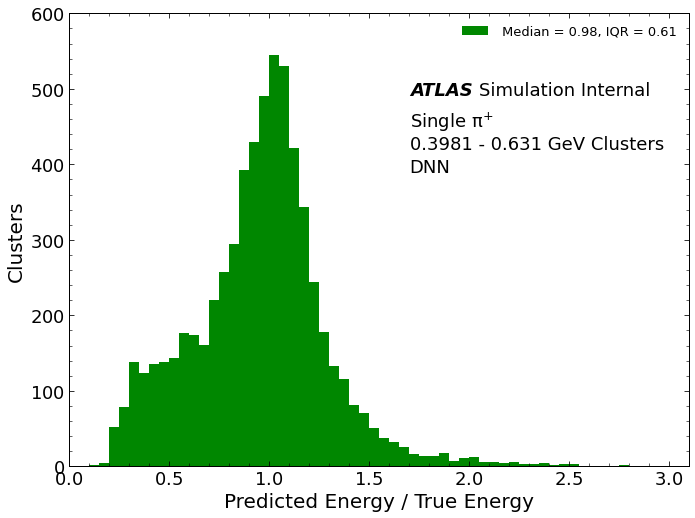

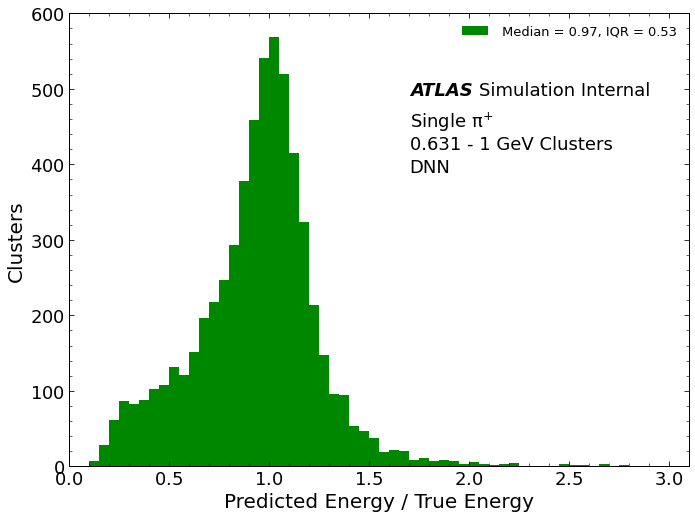

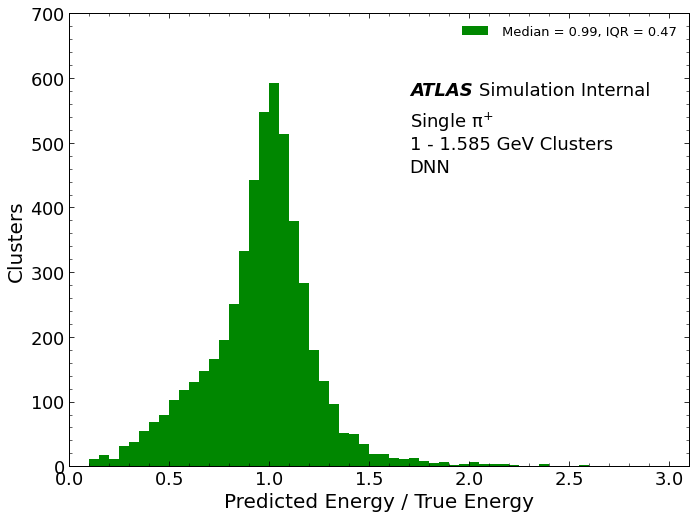

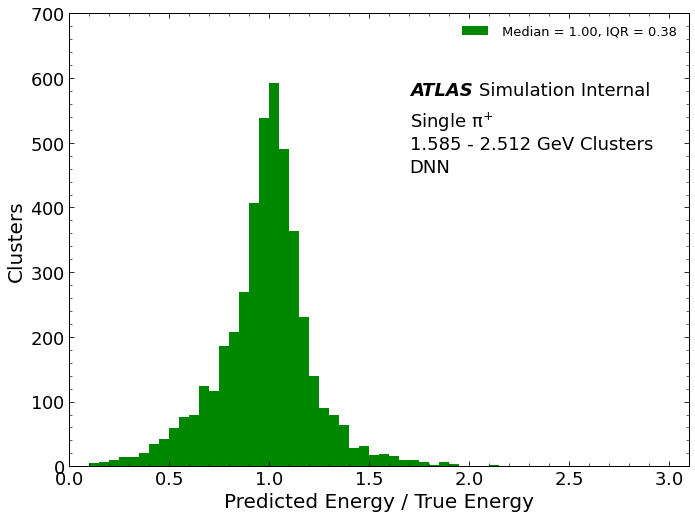

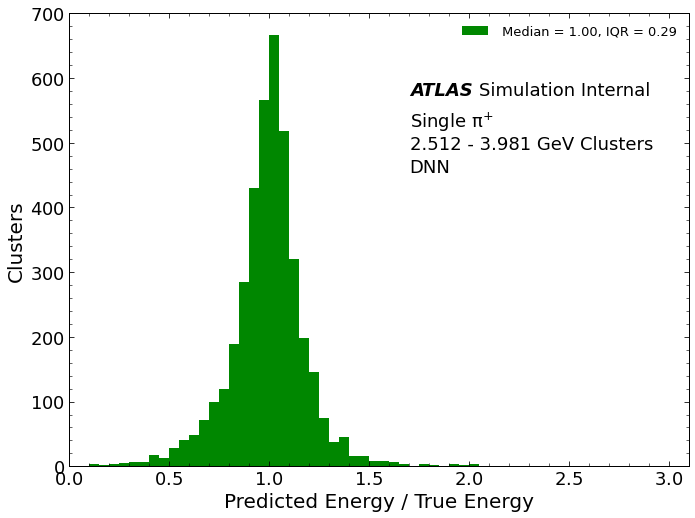

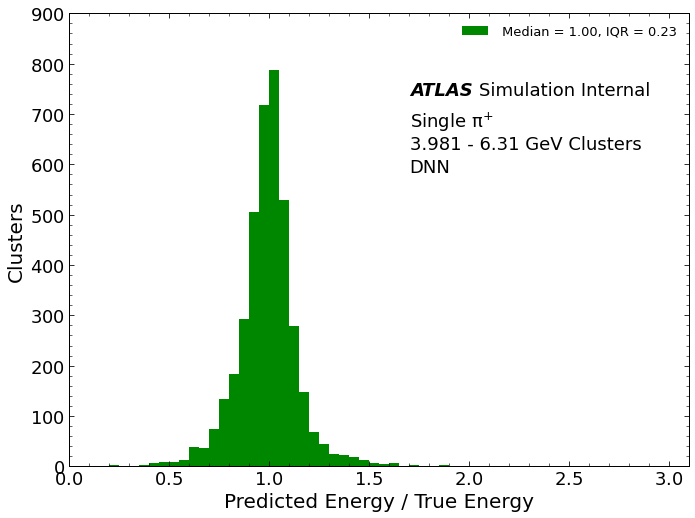

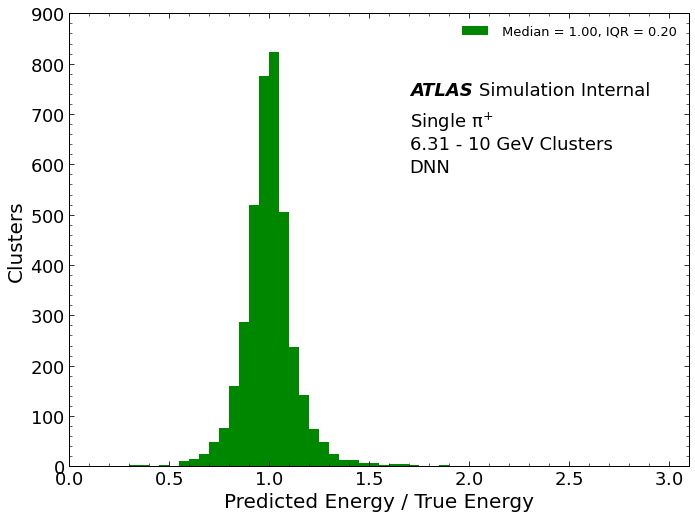

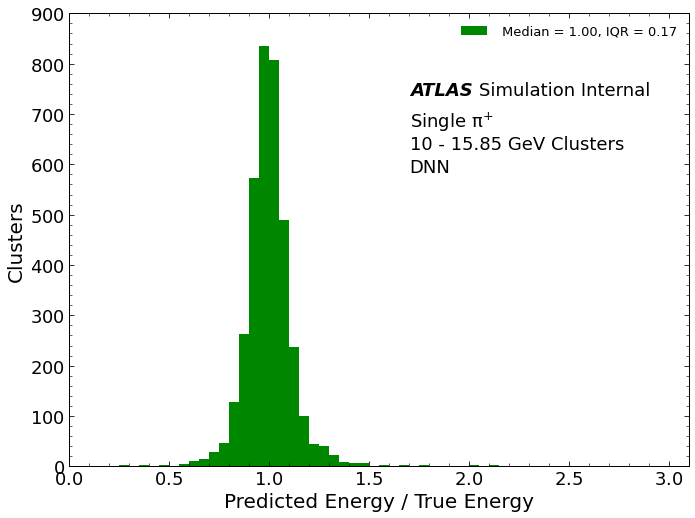

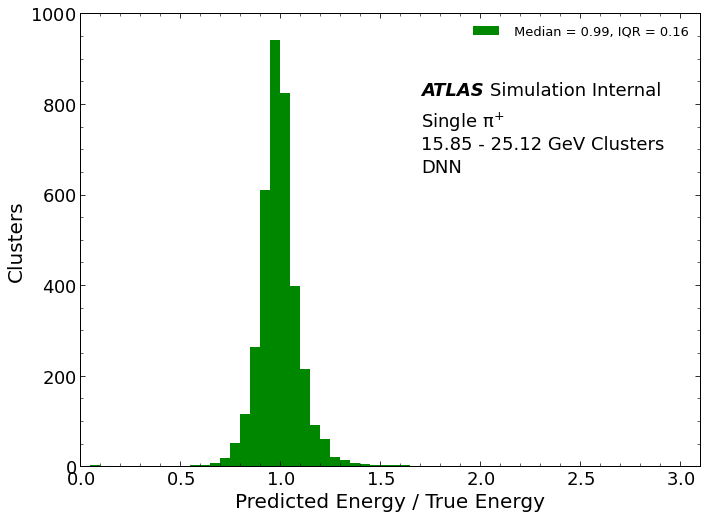

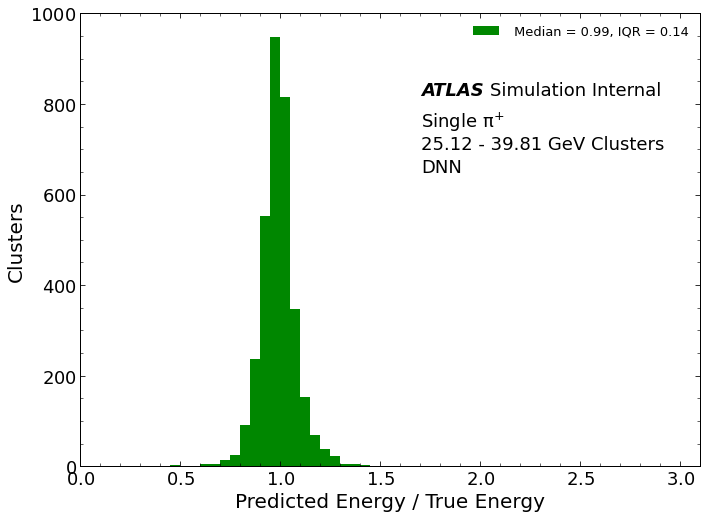

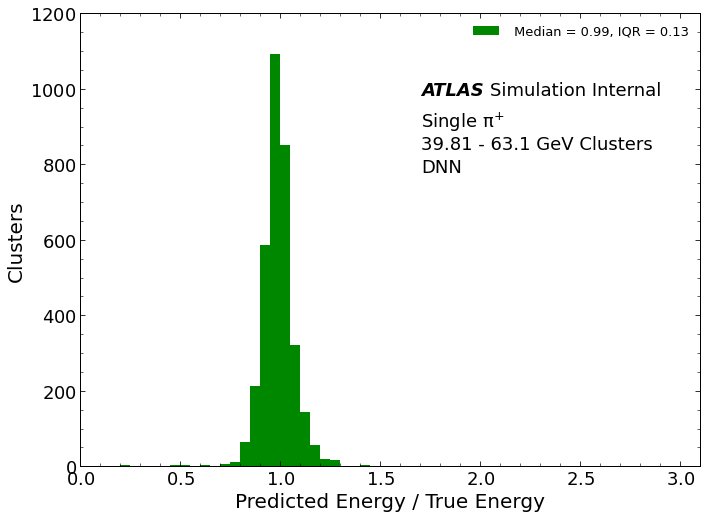

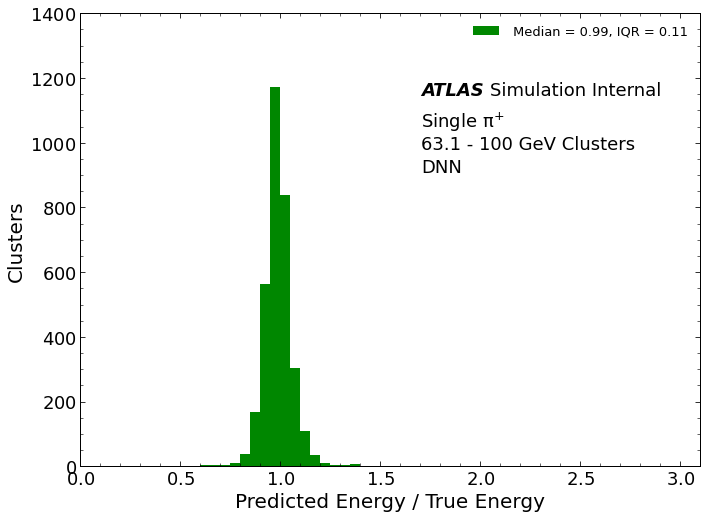

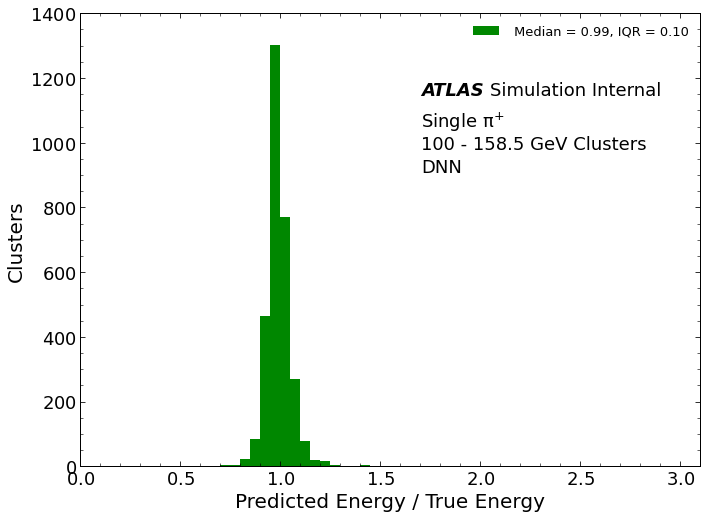

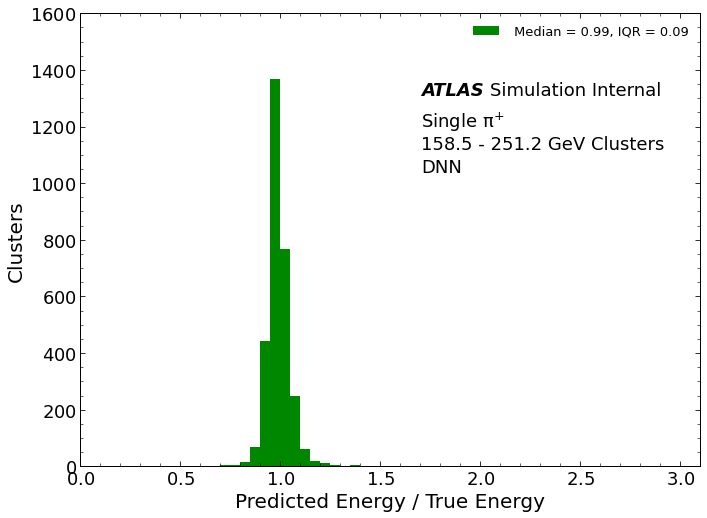

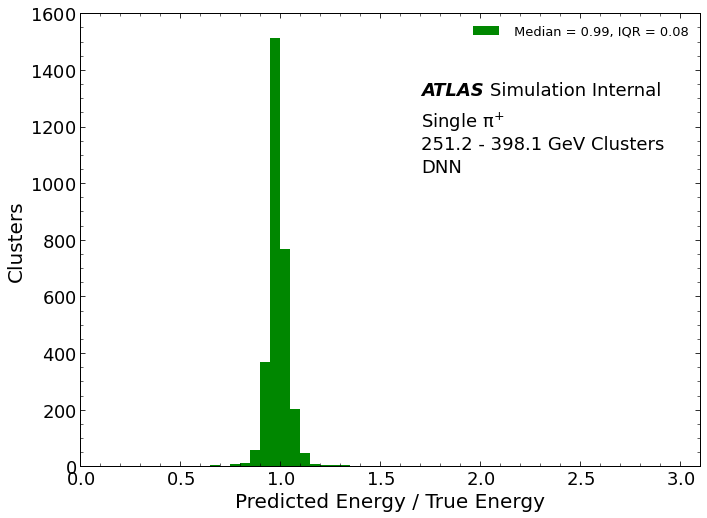

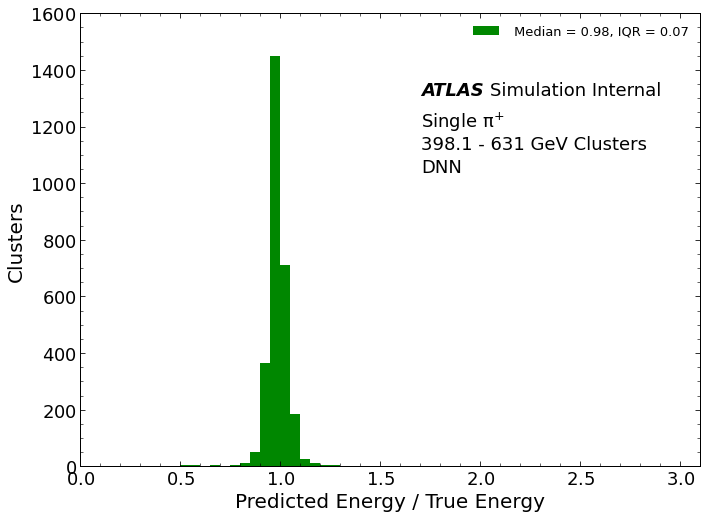

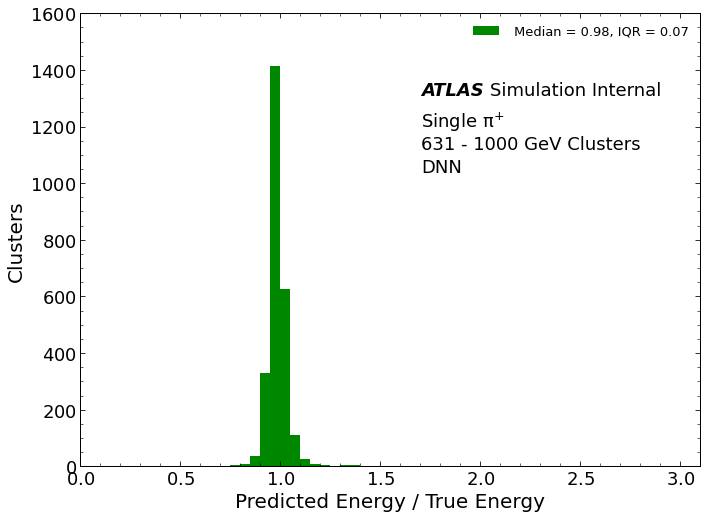

In [ ]:
histogramSlices(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'DNN'}])

#### Interquantile Range

In [ ]:
# xcenter, iqrOverMedDNN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
#                         pp[pp.test].predict_regressor_DNN_EoverCalib, statistic='iqrOverMed')

<Figure size 799.992x599.976 with 0 Axes>

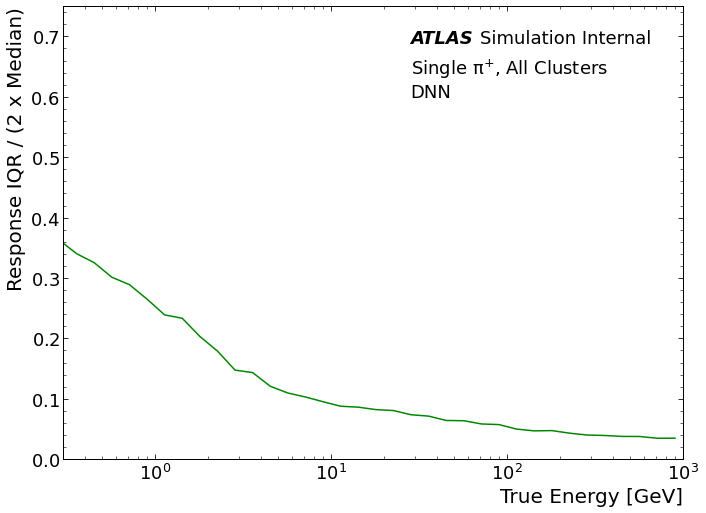

In [ ]:
xcenter, iqrDNN = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_DNN_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'DNN'}])

## MDN

In [ ]:
loadModel = True

In [ ]:
# Want to get pdf, cdf, or 0.16 and 0.84 quantiles from X
# Where X is a MixtureSameFamily object from tensorflow probability
# MixtureSameFamily doesn't have quantile() implemented... yet.
# xbin = [10**exp for exp in np.arange(-1.0, 3.1, 0.1)]
def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def MDN():
    event_shape = [1]
    num_components = 1
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
        
        # model.add(tfp.layers.MixtureNormal(num_components, event_shape, convert_to_tensor_fn=convert_to_tensor))
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor))

        opt = Adam(learning_rate=1e-4)#, decay=1e-6)
        model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

In [ ]:
regressor_All = KerasRegressor(build_fn=MDN, batch_size=100, epochs=100, verbose=1)
print(MDN().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_5 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_6 (Dense)       

In [ ]:
if loadModel:
    regressor_All = MDN()
    regressor_All.load_weights(modelpath + 'mdn_regressor.h5')
else:
    chkpoint = tf.keras.callbacks.ModelCheckpoint(modelpath + 'mdn_regressor.h5', monitor='loss', verbose=1, save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, verbose=0, restore_best_weights=True)
    history_mdn = regressor_All.fit(All_input[pp.train], 
                                             pp[pp.train].s_logECalib.to_numpy(),
                                            #  validation_split=0.1,
                                             callbacks=[chkpoint, earlystop])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


### Results

#### Residual

In [ ]:
pred = regressor_All.predict(All_input)
pp['predict_regressor_MDN'] = np.exp(scaler_cal.inverse_transform(pred[:,0]))
pp['predict_regressor_MDN_EoverCalib'] = pp.predict_regressor_MDN / pp.cluster_ENG_CALIB_TOT

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

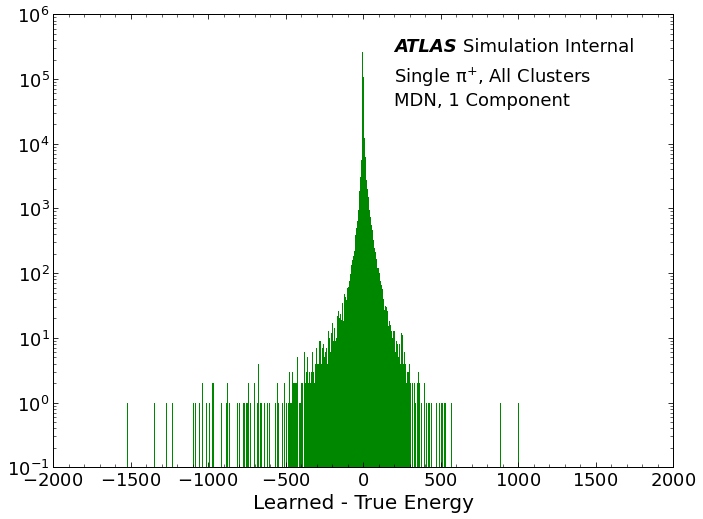

In [ ]:
resid_MDN = pp.predict_regressor_MDN-pp.cluster_ENG_CALIB_TOT
resid_MDN_mask = np.logical_and(resid_MDN < 2000, resid_MDN > -2000)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_MDN[resid_MDN_mask],bins = n_bins, 
        #  label='Mean = {:.2f}, Std. Dev. = {:.2f}'.format(np.mean(resid_MDN[resid_MDN_mask]),
        #                                                   np.std(resid_MDN[resid_MDN_mask]))
         )
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-2000,2000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'MDN, 1 Component'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

Number of outliers that lie outside the plotted range

In [ ]:
np.sum(np.logical_not(resid_MDN_mask))

0

#### Response

<Figure size 799.992x599.976 with 0 Axes>

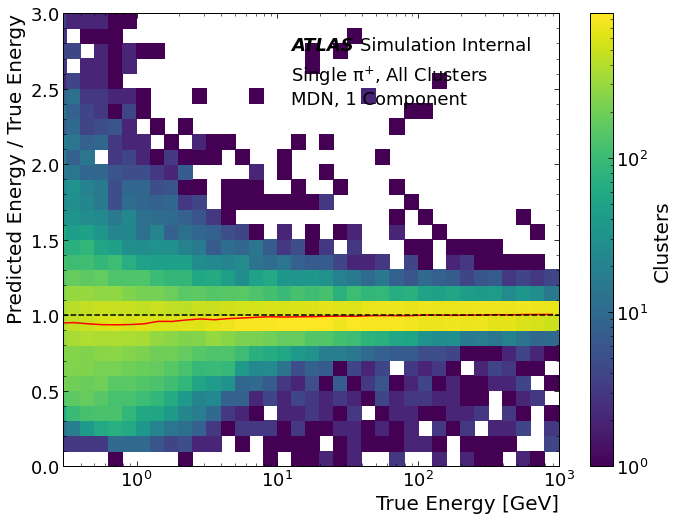

In [ ]:
xcenter, medMDN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'MDN, 1 Component'}])

In [ ]:
# xcenter, medRegMDN = responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN_EoverCalib,
#                  plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
#                  'median',
#                  atlas_x = 0.46, atlas_y = 0.95, simulation = True,
#                  textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
#                              {'x': 0.46, 'y': 0.8,  'text': 'MDN, 1 Component'}])

#### Response Histogram Slices

<Figure size 799.992x599.976 with 0 Axes>

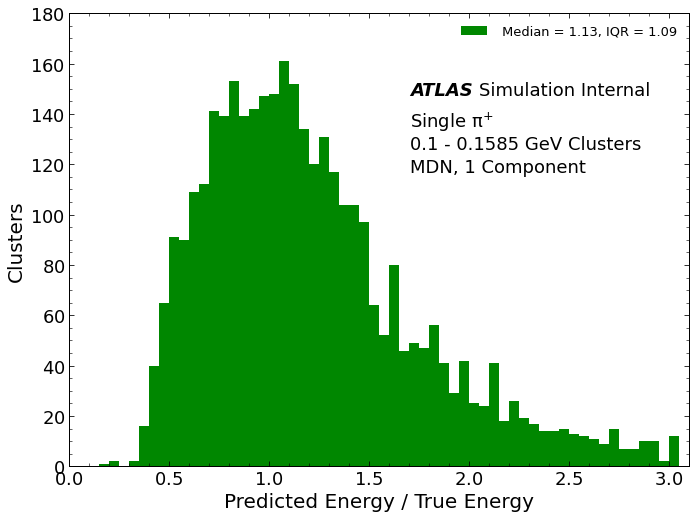

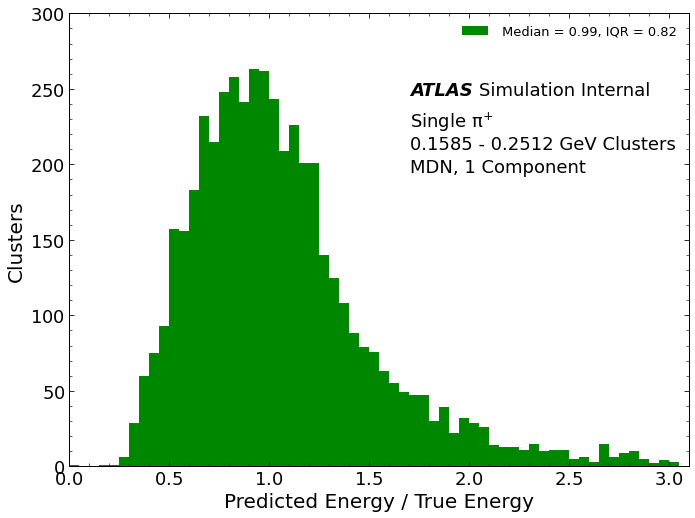

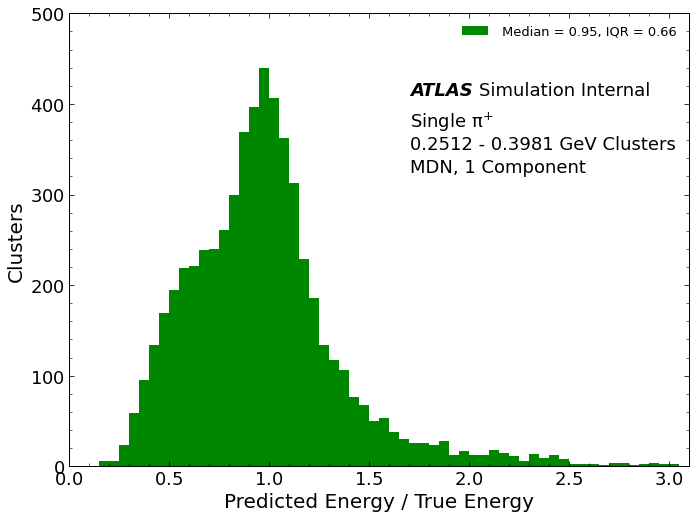

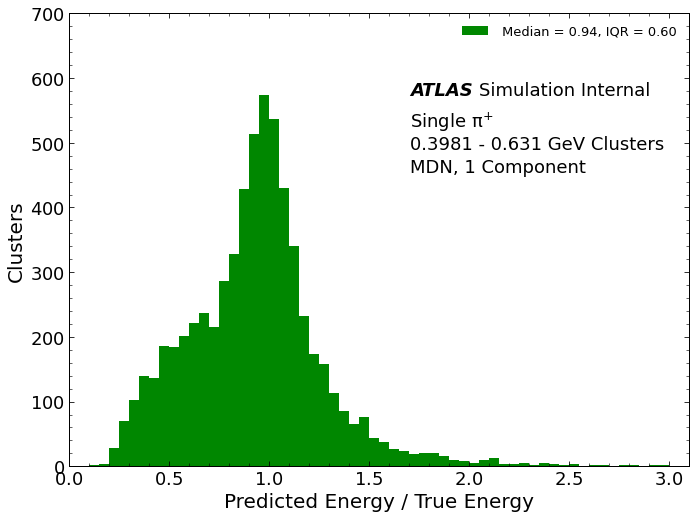

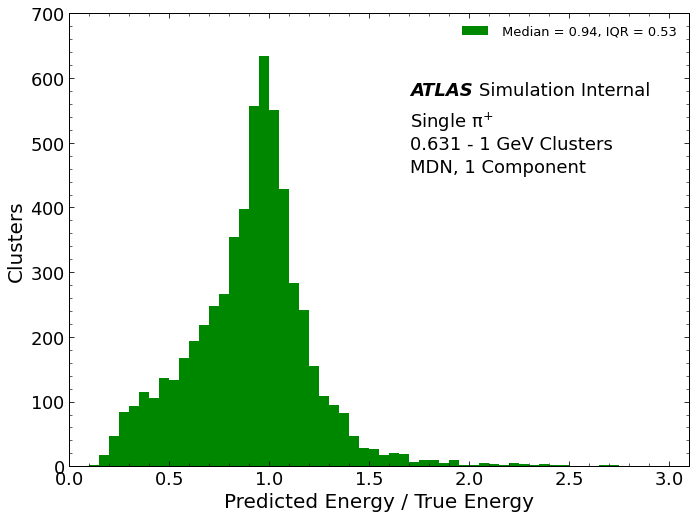

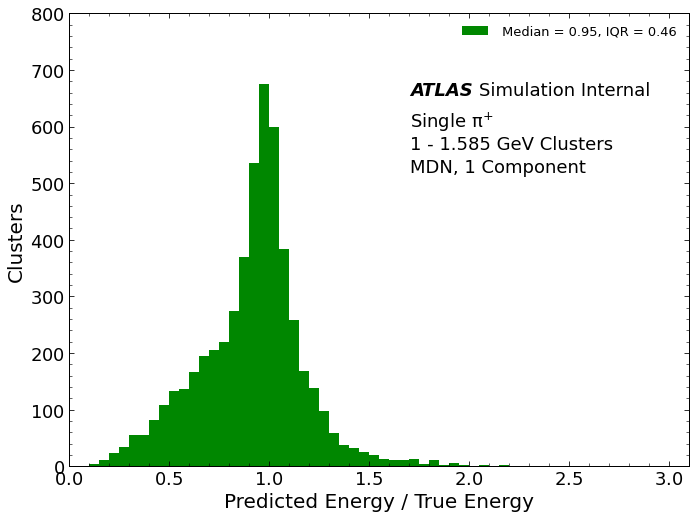

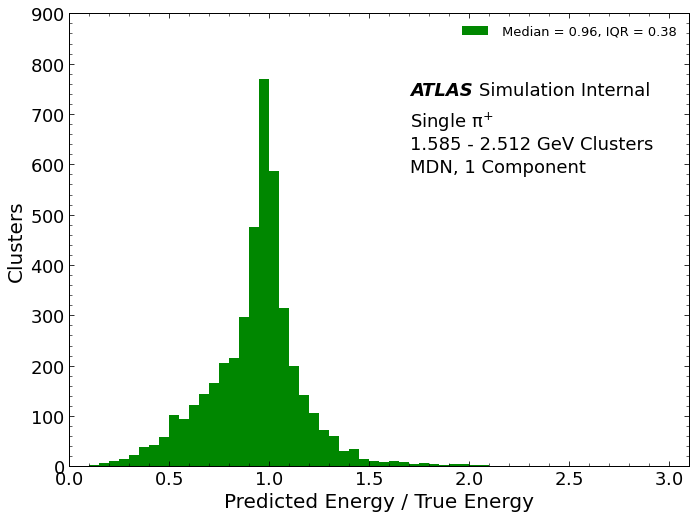

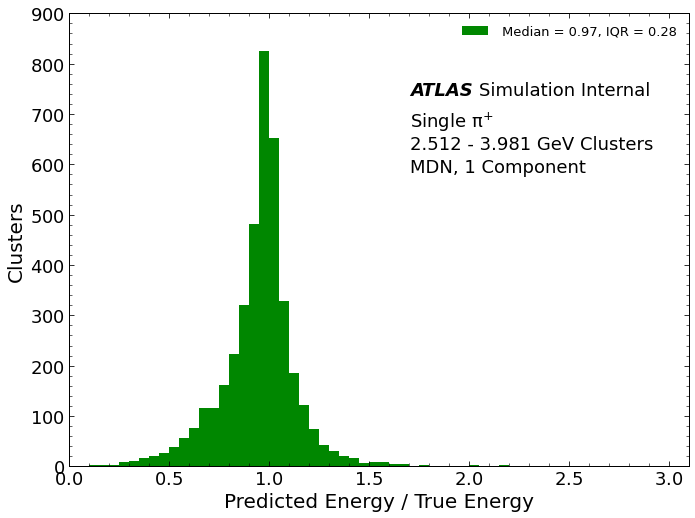

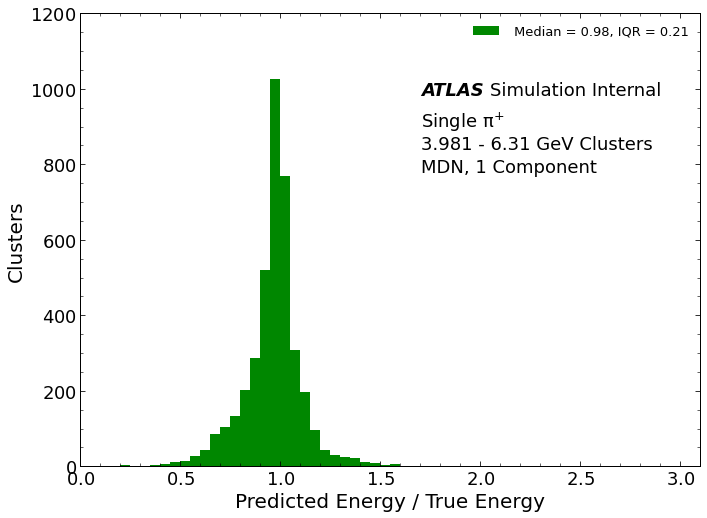

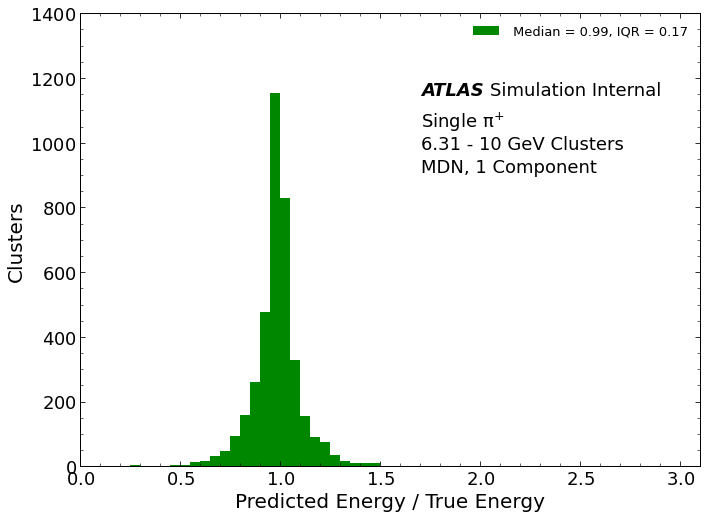

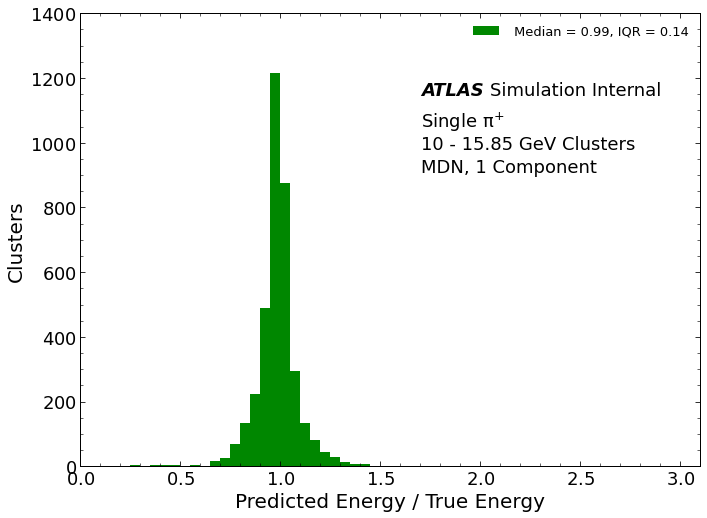

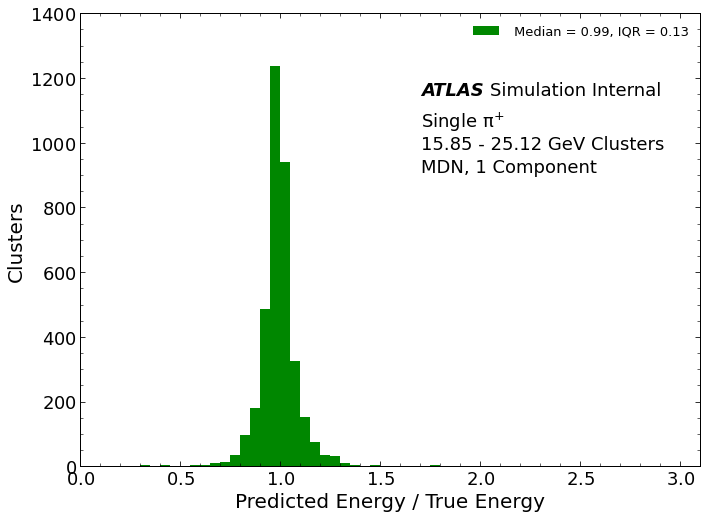

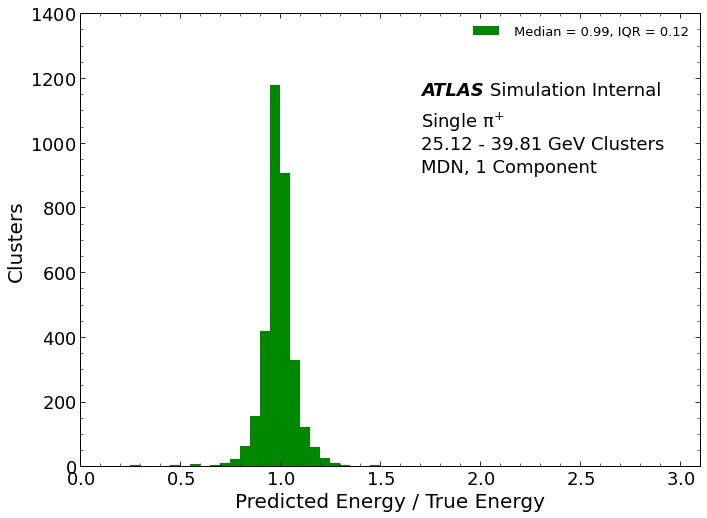

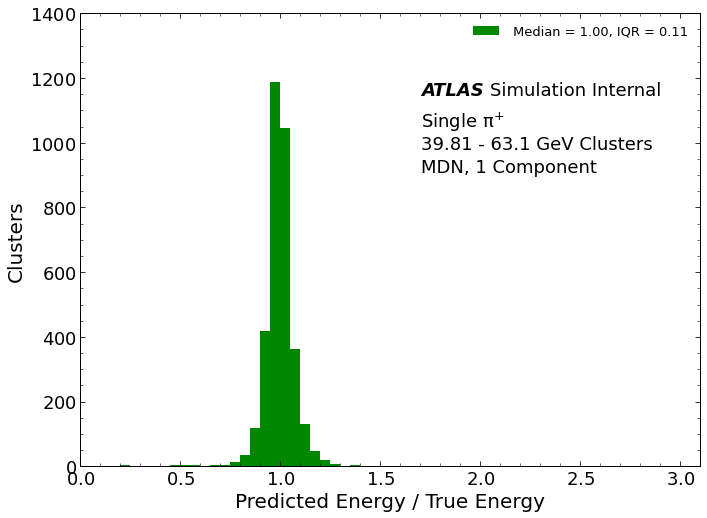

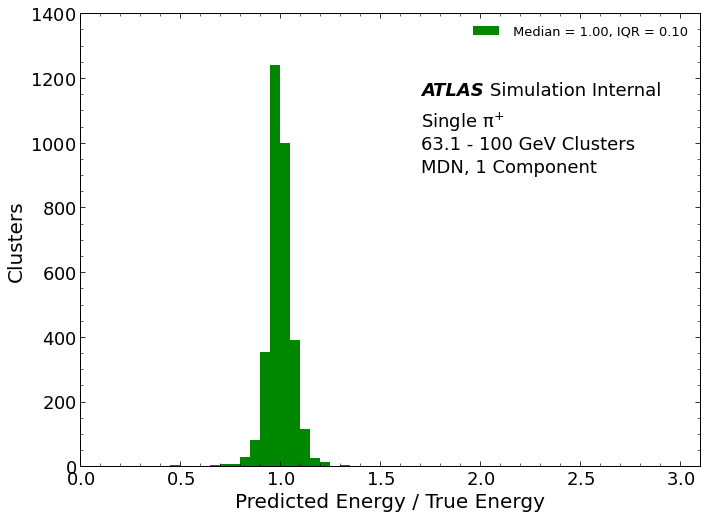

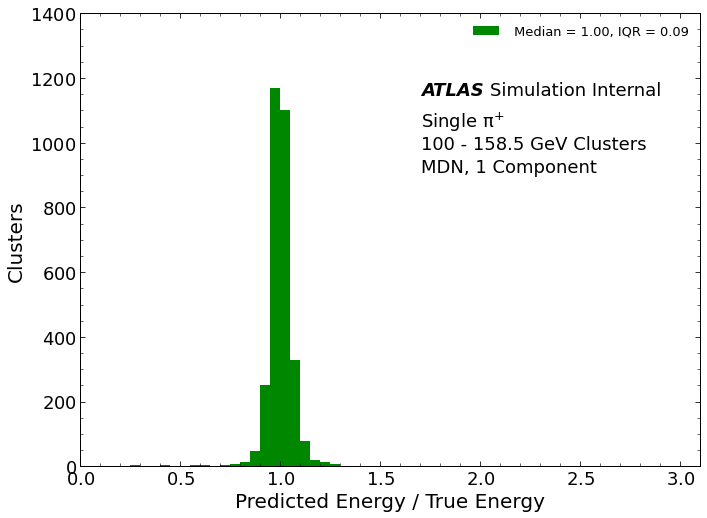

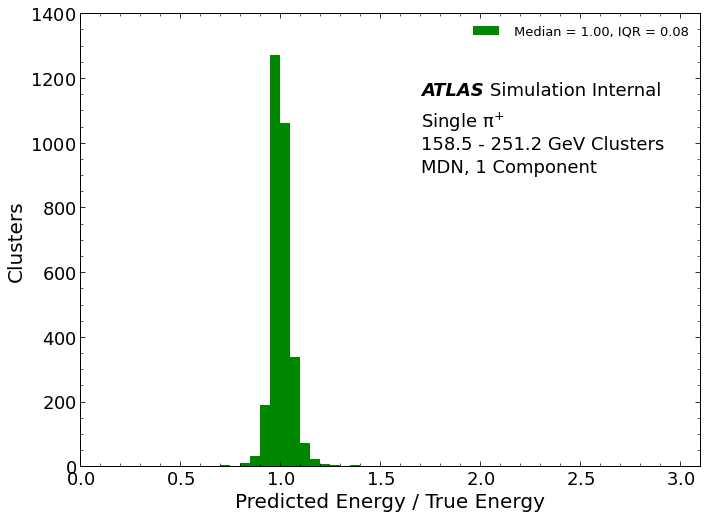

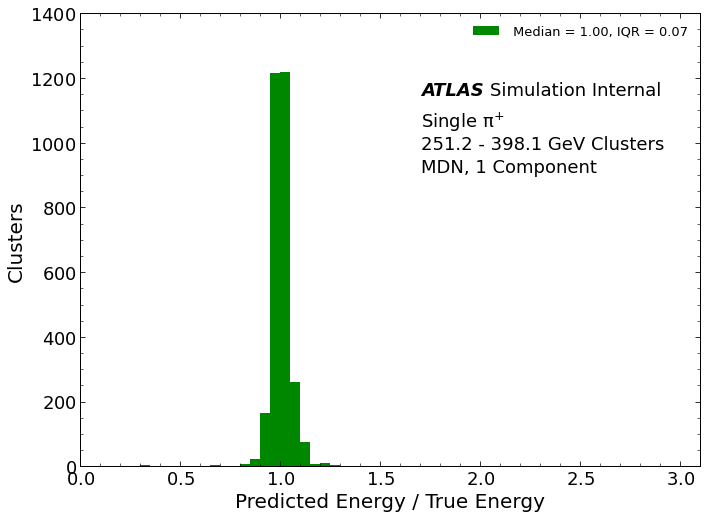

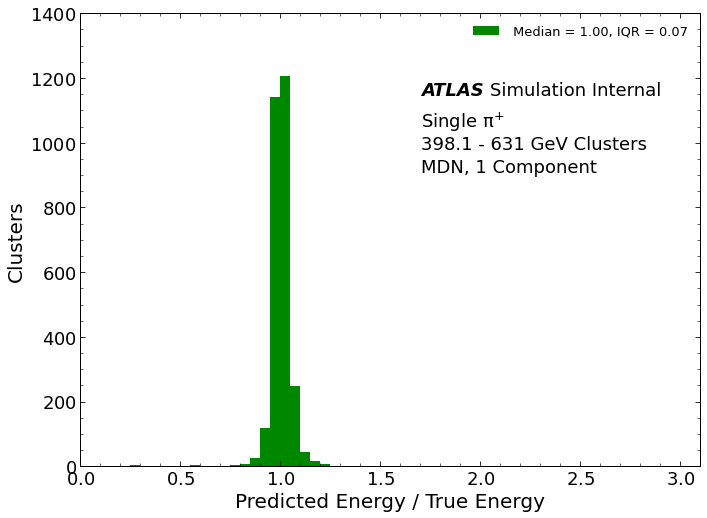

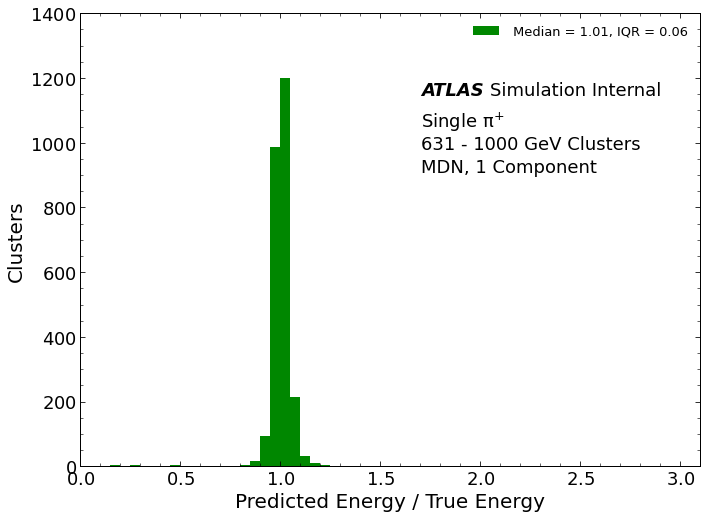

In [ ]:
histogramSlices(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN_EoverCalib,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'MDN, 1 Component'}])

#### Interquantile Range

In [ ]:
# xcenter, iqrOverMedMDN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
#                         pp[pp.test].predict_regressor_MDN_EoverCalib, statistic='iqrOverMed')

<Figure size 799.992x599.976 with 0 Axes>

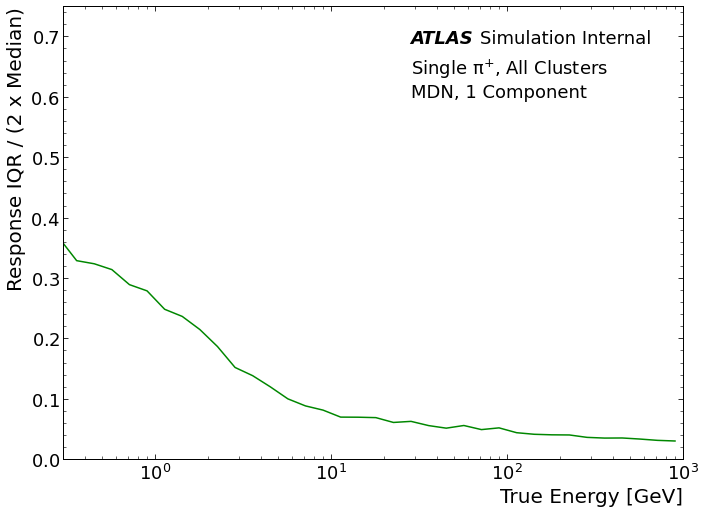

In [ ]:
xcenter, iqrMDN = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
                        pp[pp.test].predict_regressor_MDN_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'MDN, 1 Component'}])

## MDN 3 Components

In [ ]:
loadModel = True

In [ ]:
def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def MDN_3():
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
        
        # model.add(tfp.layers.MixtureNormal(num_components, event_shape, convert_to_tensor_fn=convert_to_tensor))
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor))

        opt = Adam(learning_rate=1e-4)#, decay=1e-6)
        model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

In [ ]:
regressor_All = KerasRegressor(build_fn=MDN_3, batch_size=100, epochs=100, verbose=1)
print(MDN_3().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_13 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_14 (Dense)             (None, 469)               440391    
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 4230      
_________________________________________________________________
mixture_normal_2 (MixtureNor multiple 

In [ ]:
if loadModel:
    regressor_All = MDN_3()
    regressor_All.load_weights(modelpath + 'mdn_regressor_2.h5')
else:
    chkpoint = tf.keras.callbacks.ModelCheckpoint(modelpath + 'mdn_regressor_2.h5', monitor='loss', verbose=1, save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, verbose=0, restore_best_weights=True)
    history_mdn3 = regressor_All.fit(All_input[pp.train], 
                                             pp[pp.train].s_logECalib.to_numpy(),
                                            #  validation_split=0.1,
                                             callbacks=[chkpoint, earlystop])

### Results

#### Residual

In [ ]:
pred = regressor_All.predict(All_input)
pp['predict_regressor_MDN3'] = np.exp(scaler_cal.inverse_transform(pred[:,0]))
pp['predict_regressor_MDN3_EoverCalib'] = pp.predict_regressor_MDN3 / pp.cluster_ENG_CALIB_TOT

No handles with labels found to put in legend.


<Figure size 799.992x599.976 with 0 Axes>

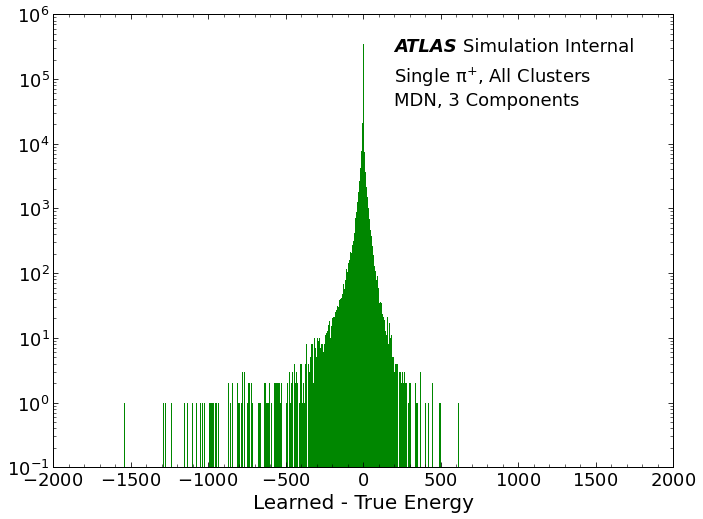

In [ ]:
resid_MDN3 = pp.predict_regressor_MDN3-pp.cluster_ENG_CALIB_TOT
resid_MDN3_mask = np.logical_and(resid_MDN3 < 2000, resid_MDN3 > -2000)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_MDN3[resid_MDN3_mask],bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-2000,2000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

Number of outliers not plotted

In [ ]:
np.sum(np.logical_not(resid_MDN3_mask))

1

#### Response

<Figure size 799.992x599.976 with 0 Axes>

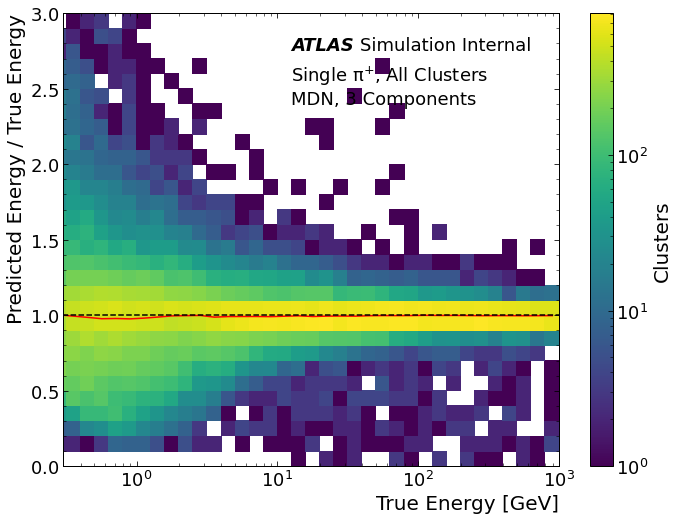

In [ ]:
xcenter, medMDN3 = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN3_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'MDN, 3 Components'}])

#### Response Histogram Slices

<Figure size 799.992x599.976 with 0 Axes>

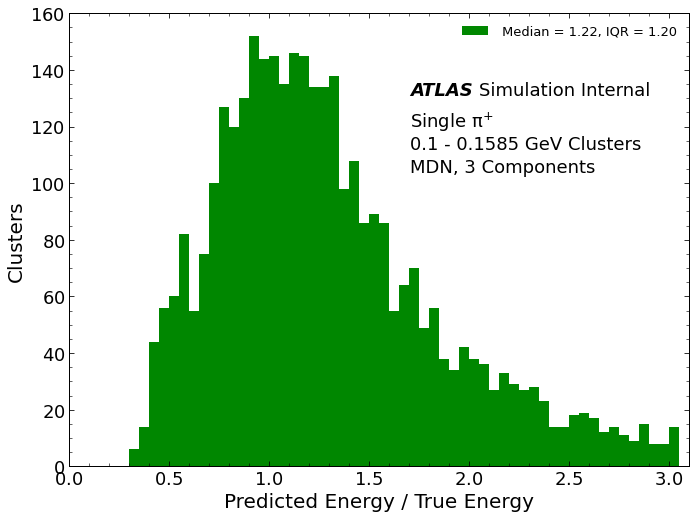

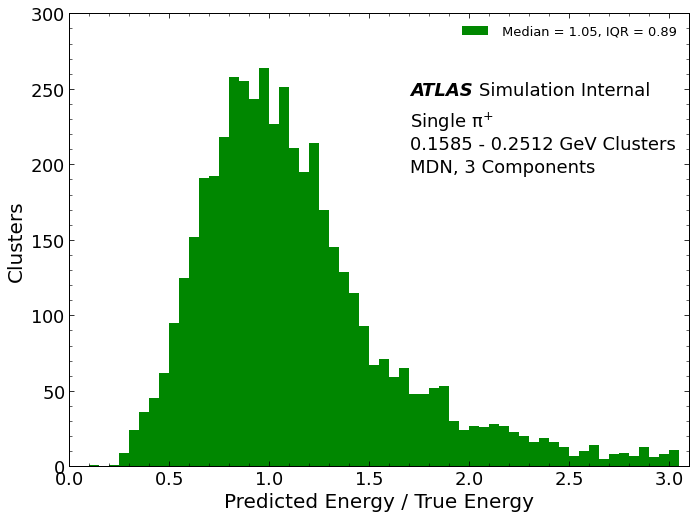

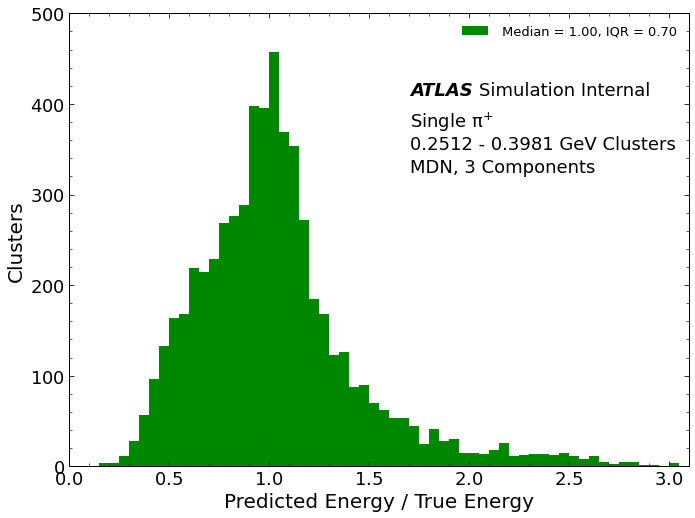

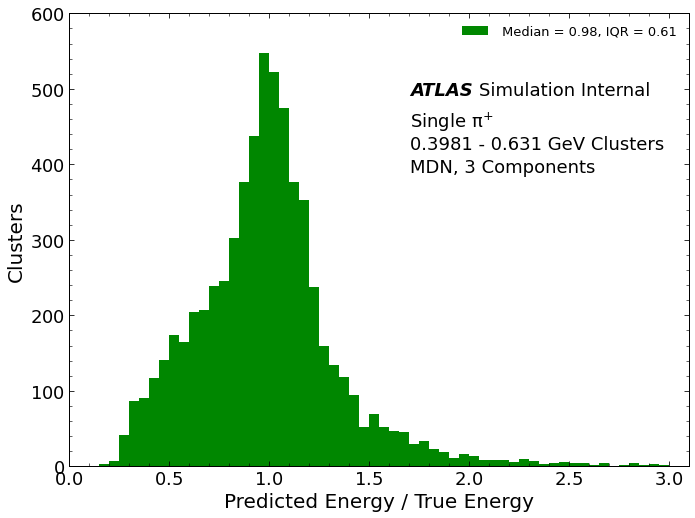

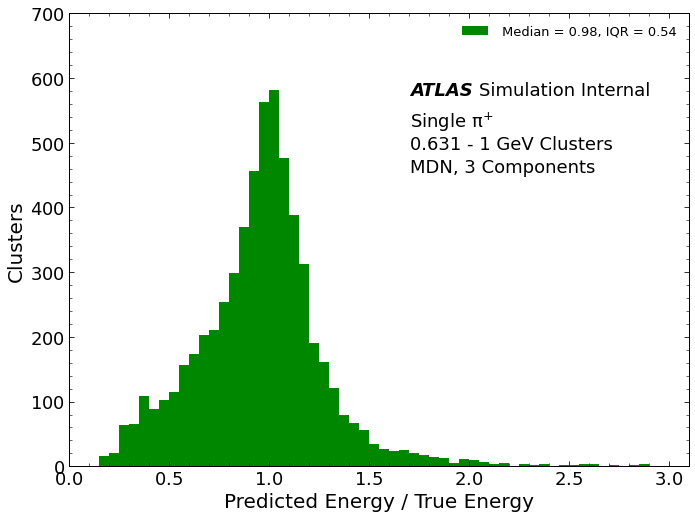

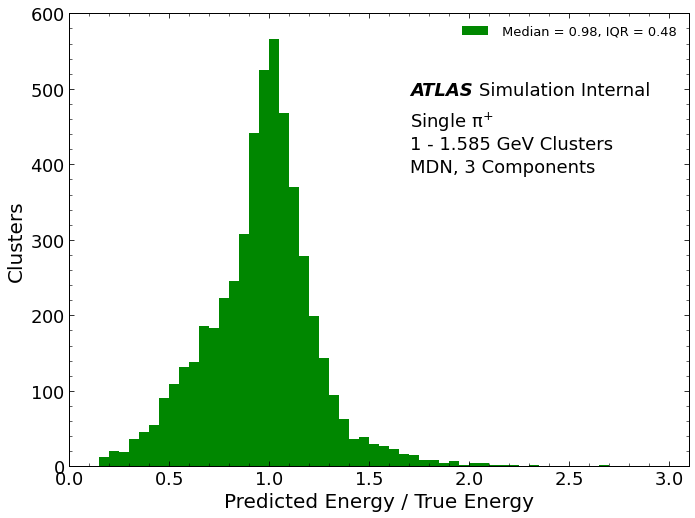

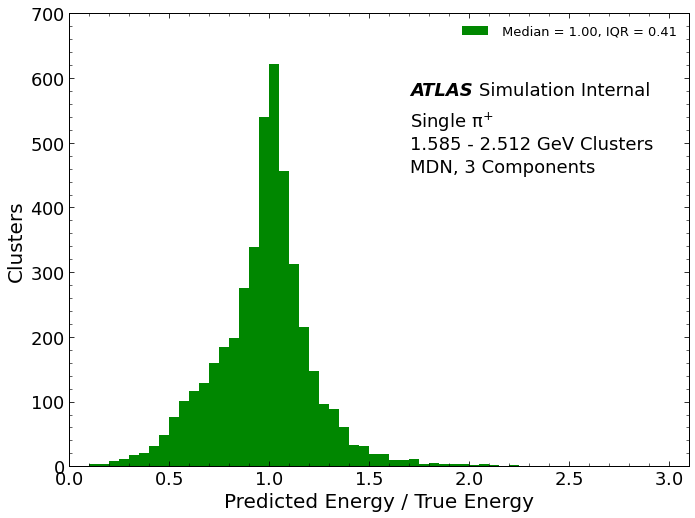

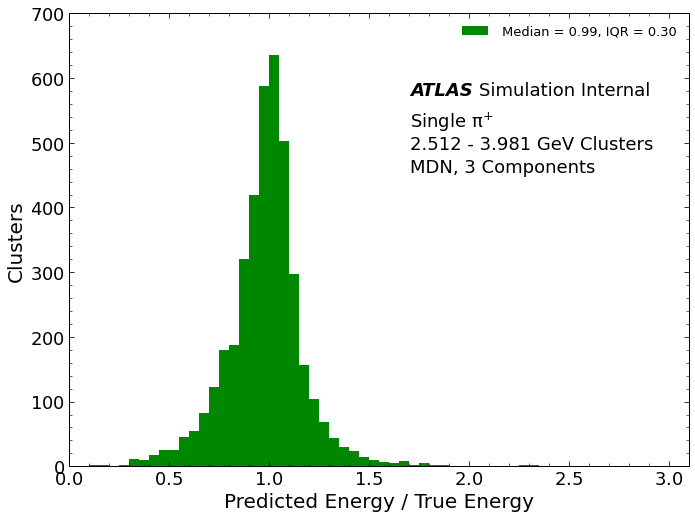

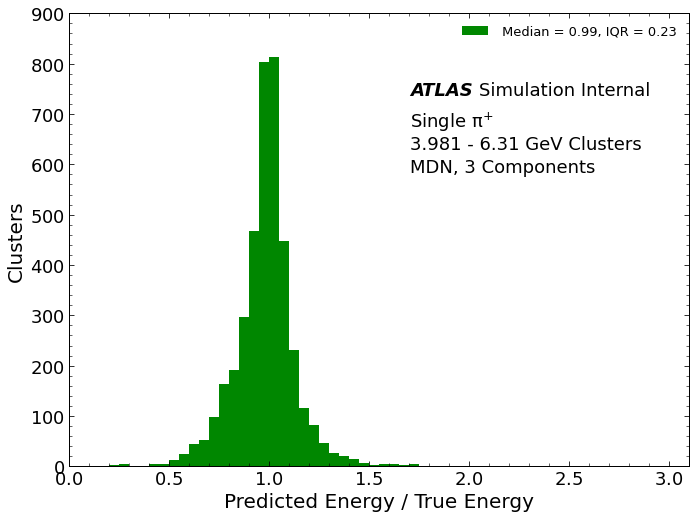

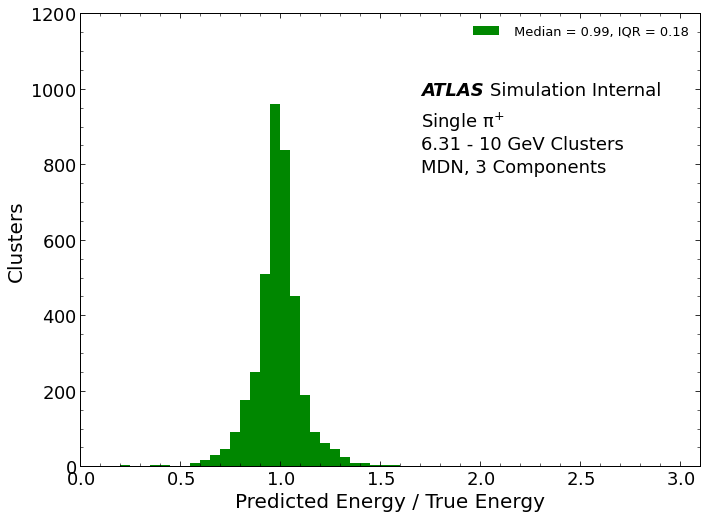

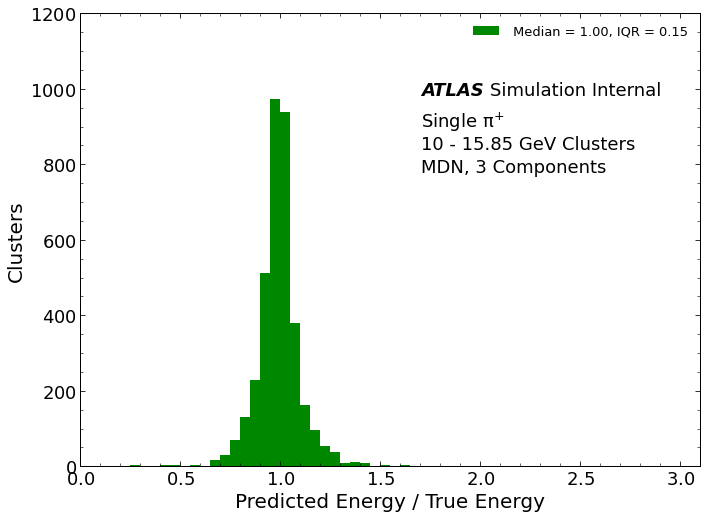

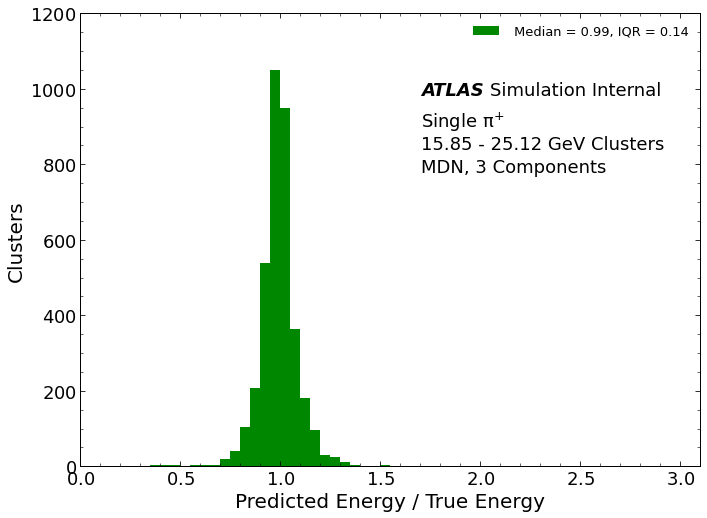

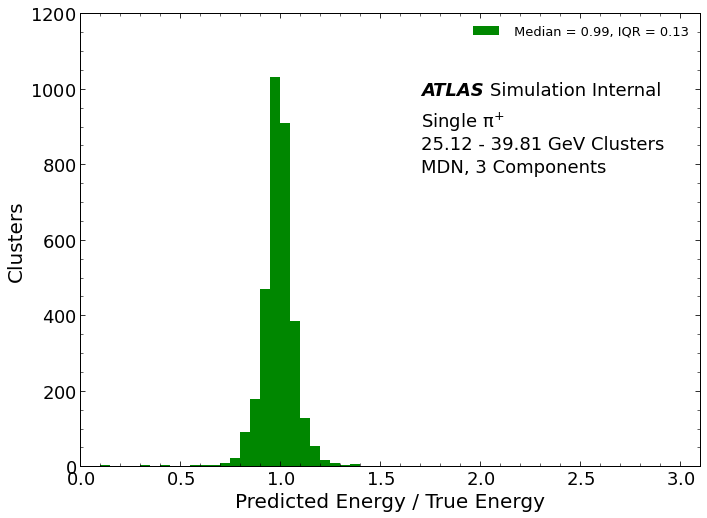

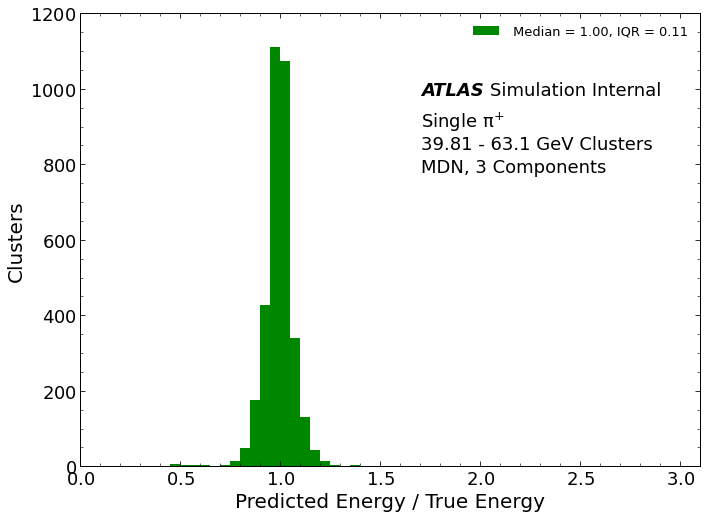

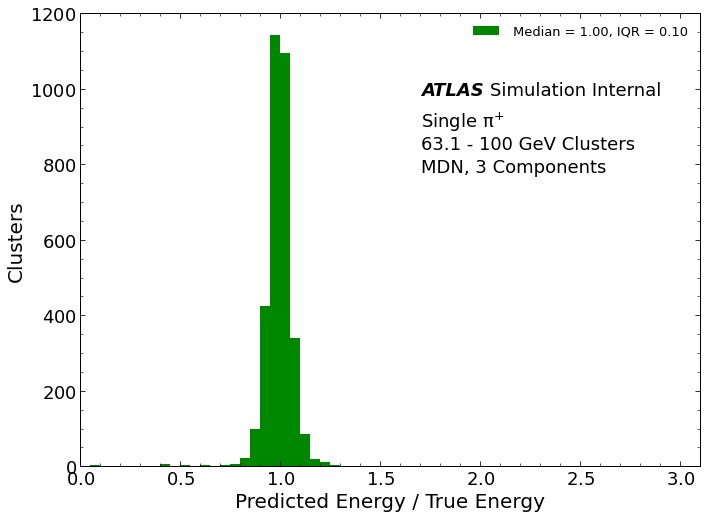

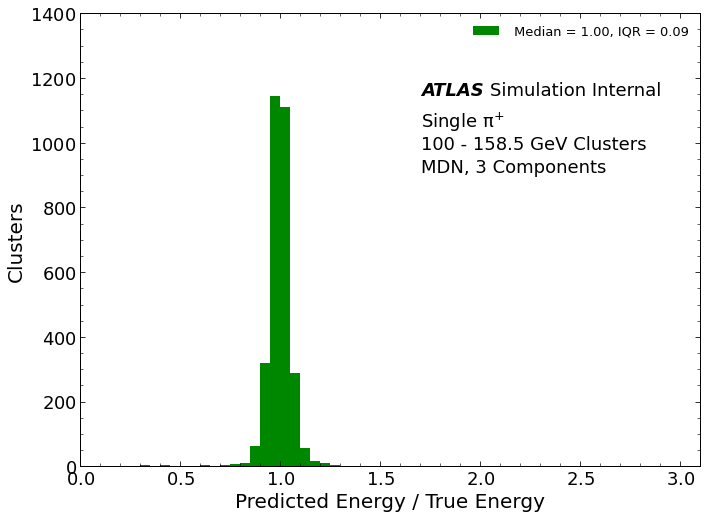

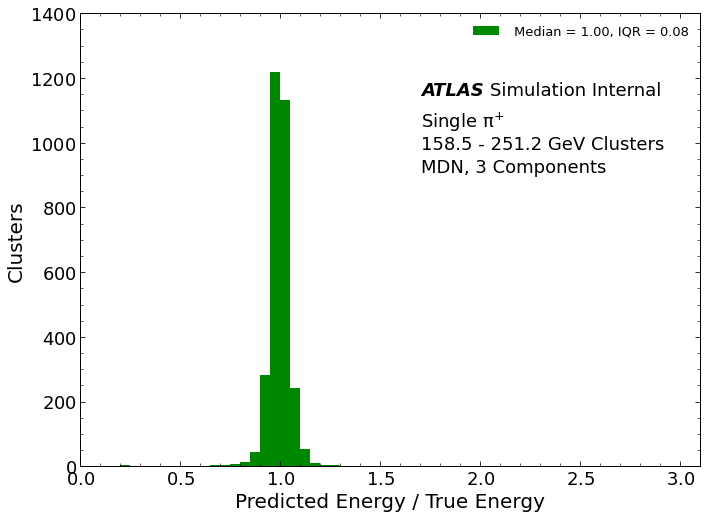

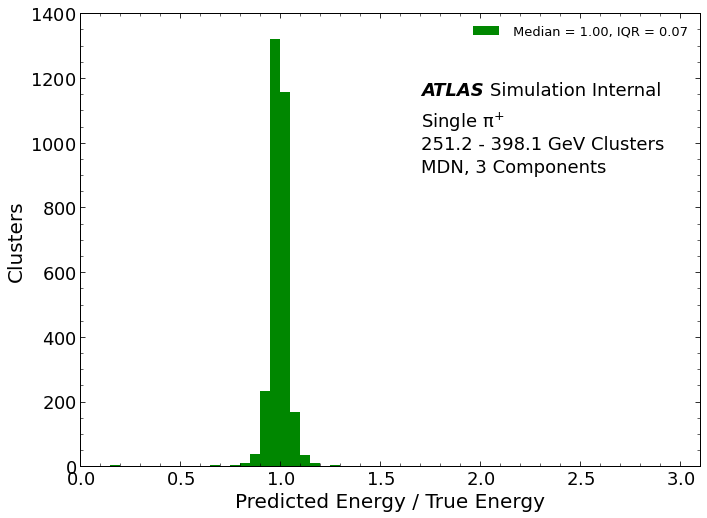

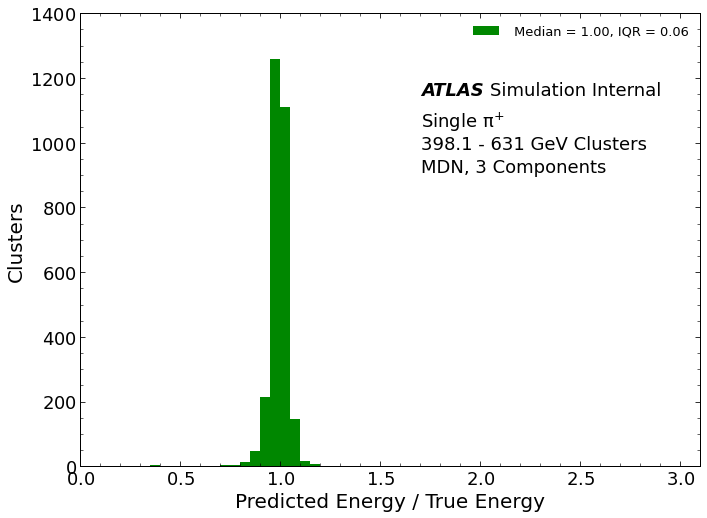

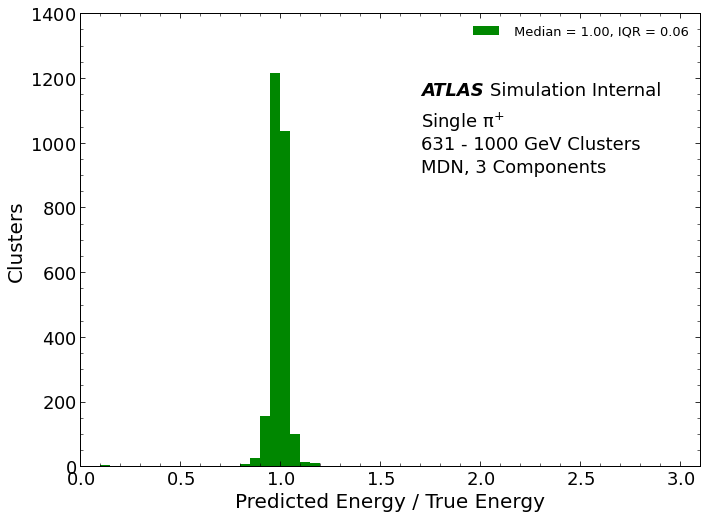

In [ ]:
histogramSlices(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN3_EoverCalib,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'MDN, 3 Components'}])

#### Interquantile Range

In [ ]:
# xcenter, iqrOverMedMDN3 = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
#                         pp[pp.test].predict_regressor_MDN3_EoverCalib, statistic='iqrOverMed')

<Figure size 799.992x599.976 with 0 Axes>

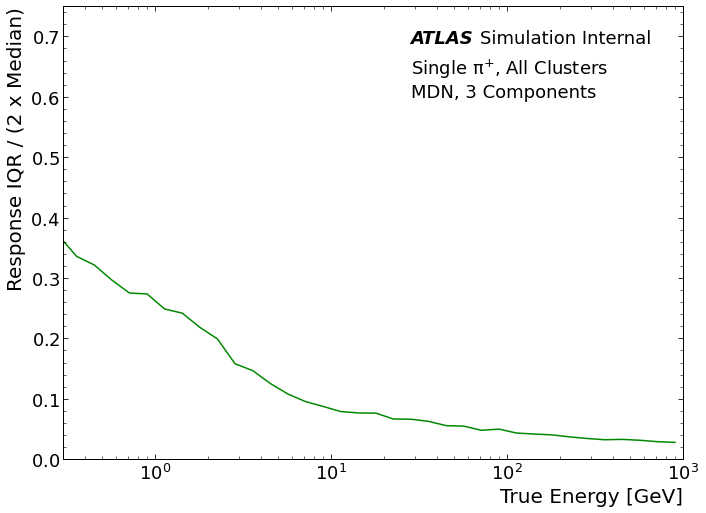

In [ ]:
xcenter, iqrMDN3 = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
                        pp[pp.test].predict_regressor_MDN3_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'MDN, 3 Components'}])

## Results Overlayed

### Residual

<Figure size 799.992x599.976 with 0 Axes>

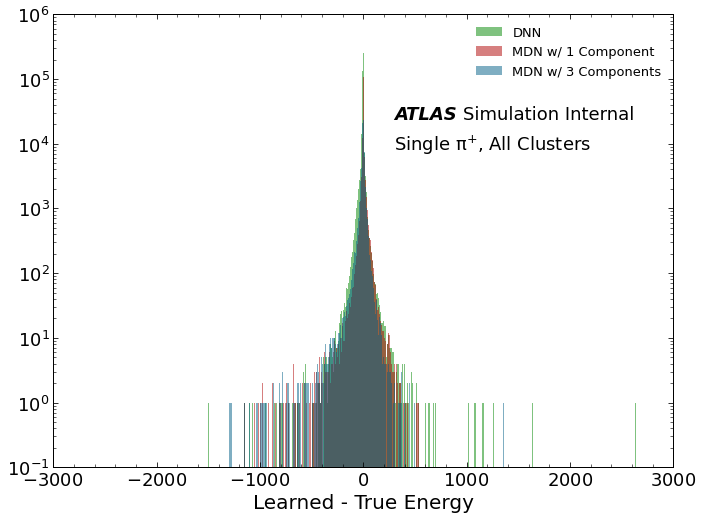

In [ ]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.5, label='DNN')
plt.hist(resid_MDN[resid_MDN_mask],bins = n_bins,alpha=0.5, label='MDN w/ 1 Component')
plt.hist(resid_MDN3[resid_MDN3_mask],bins = n_bins,alpha=0.5, label='MDN w/ 3 Components')
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.8
simulation = True
textlist = [{'x': 0.55, 'y': 0.7, 'text': 'Single $\pi^{+}$, All Clusters'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

### Response (median)

<Figure size 799.992x599.976 with 0 Axes>

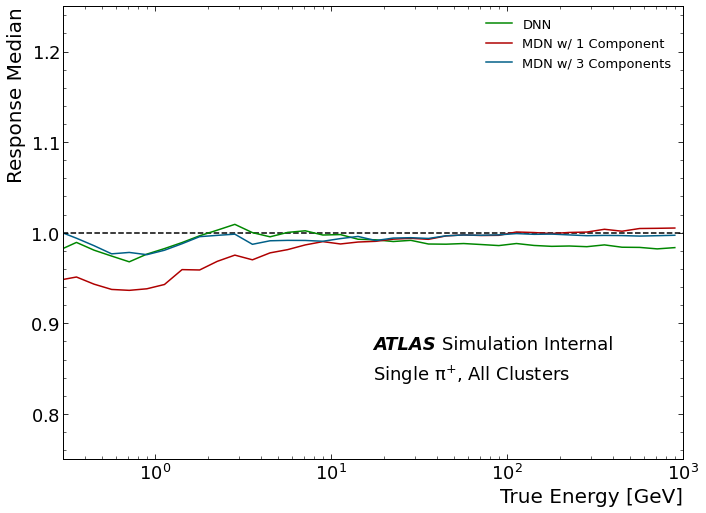

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [medDNN, medMDN, medMDN3],
                                labels = ['DNN', 'MDN w/ 1 Component', 'MDN w/ 3 Components'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response Median',
                figfile = plotpath + "hist_2D_E_vs_ratio_pp_profile_Overlay_Overlay_BaseLCAll.pdf",
                x_min = 0.3, y_min=0.75, y_max = 1.25,
                extra_lines = [[[0.1,1000],[1,1]]],
                # linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.5, atlas_y = 0.275, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.175, 'text': 'Single $\pi^{+}$, All Clusters'}])

### Response Histogram Slices

<Figure size 799.992x599.976 with 0 Axes>

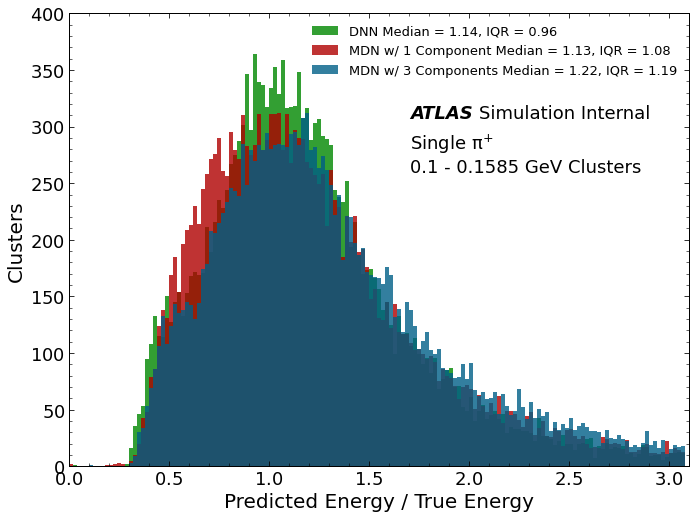

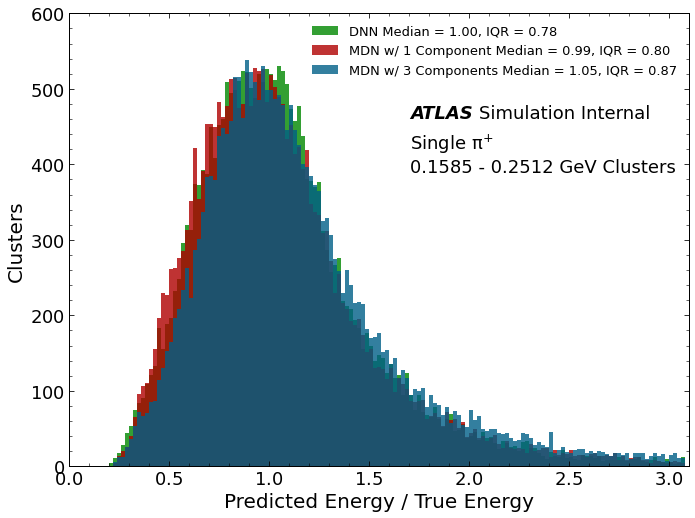

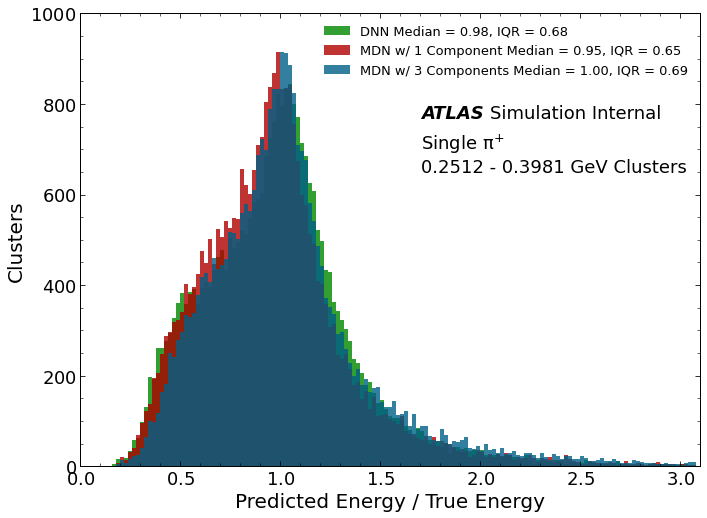

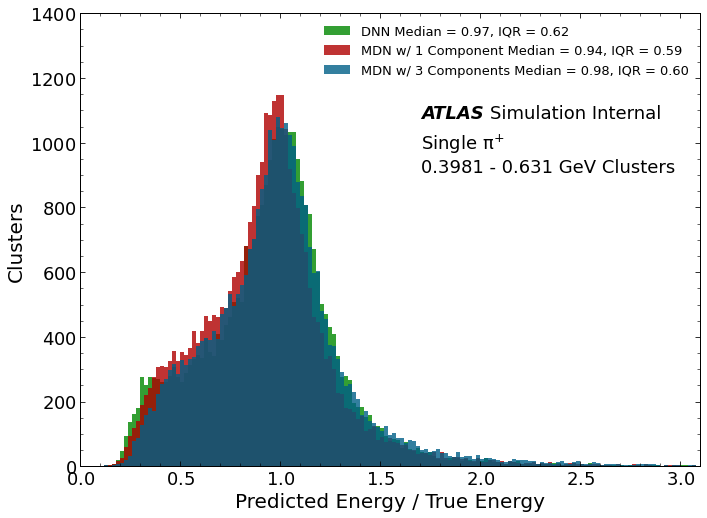

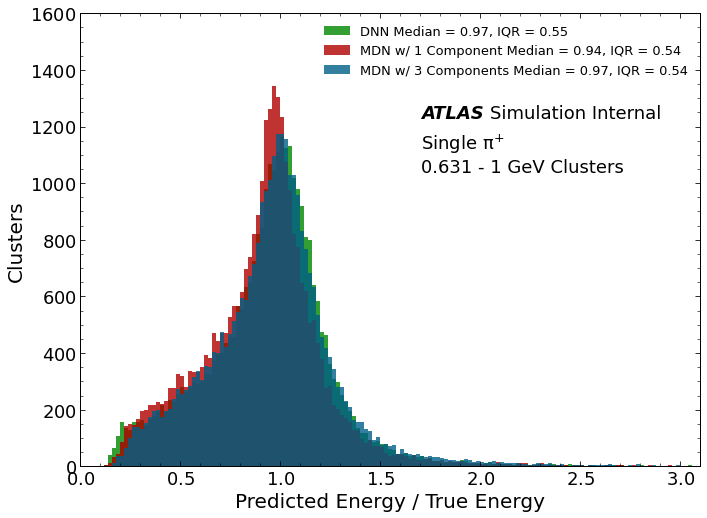

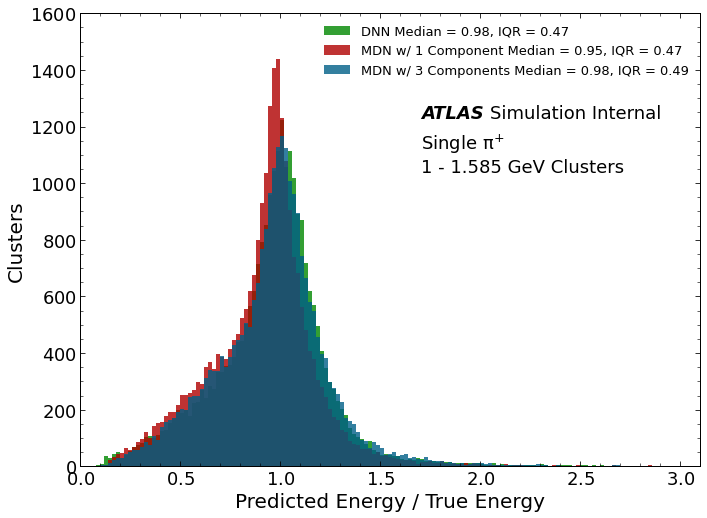

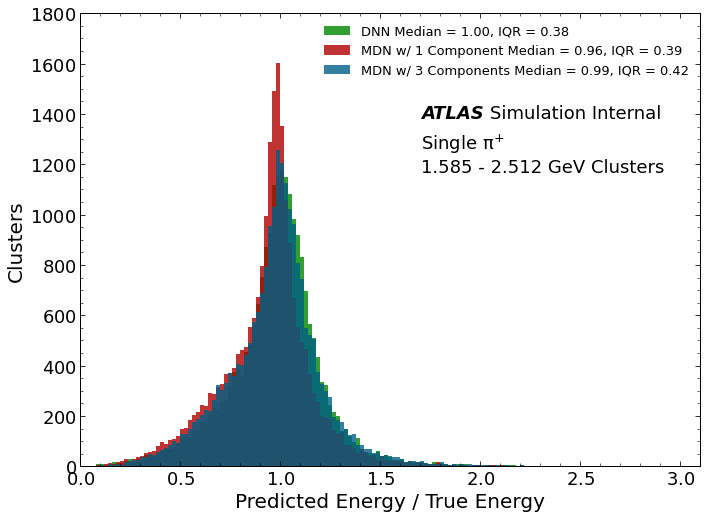

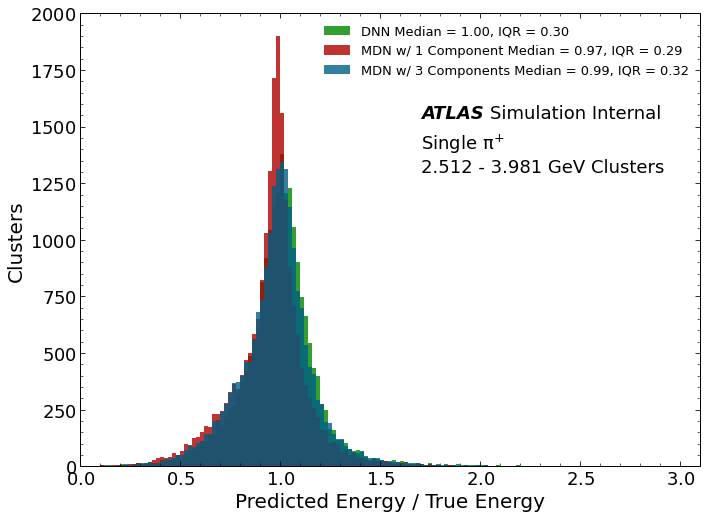

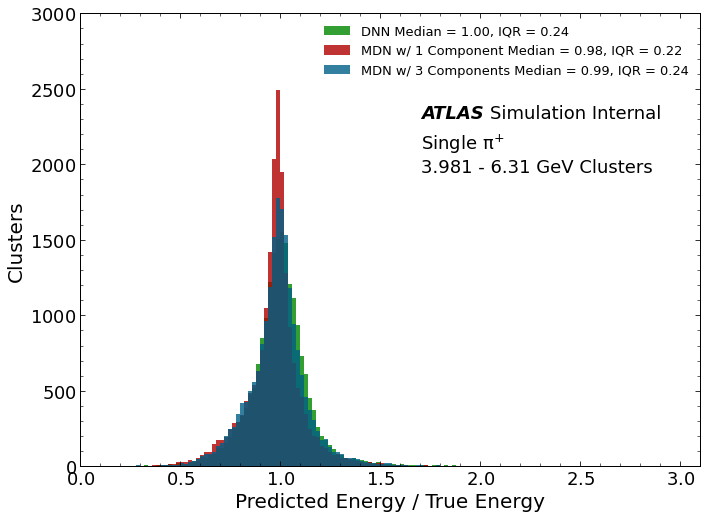

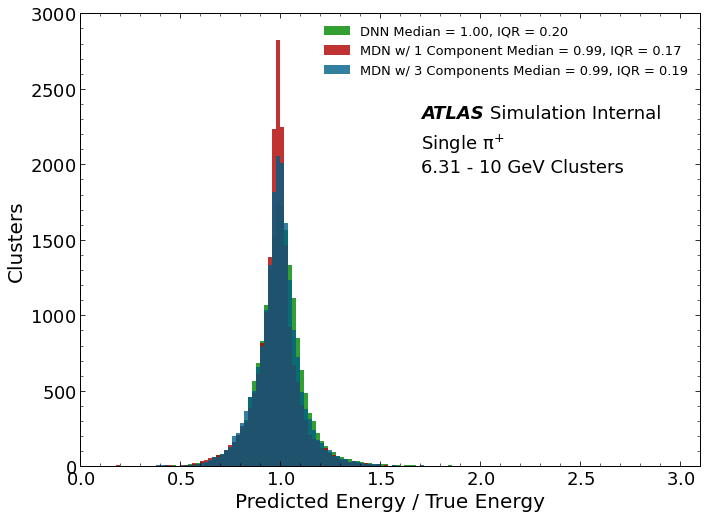

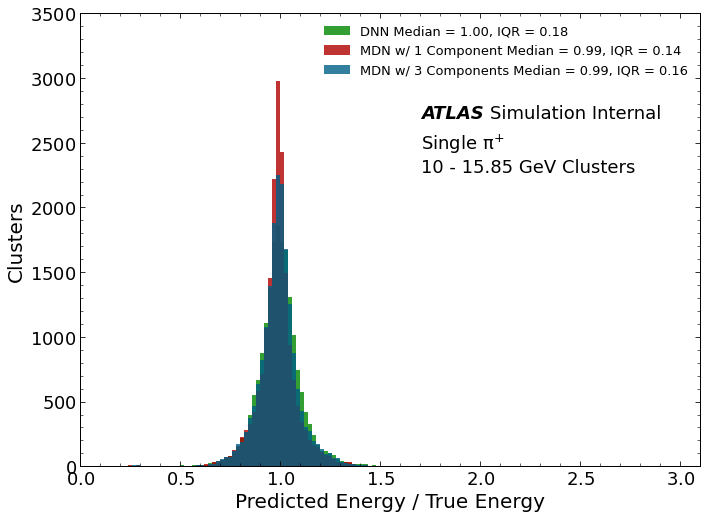

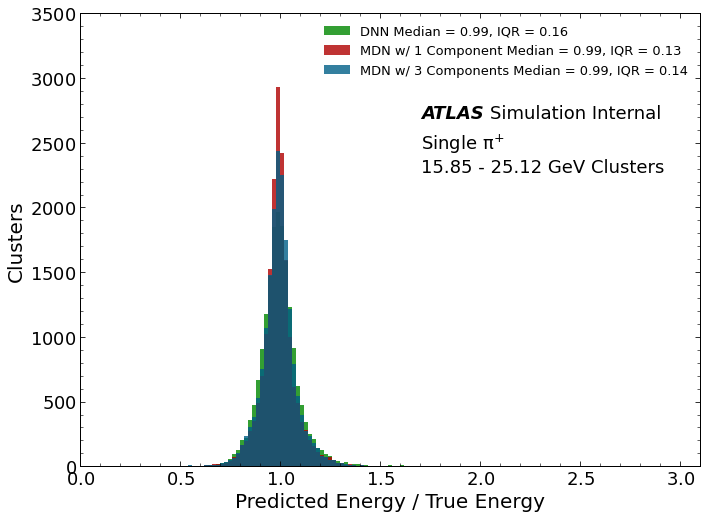

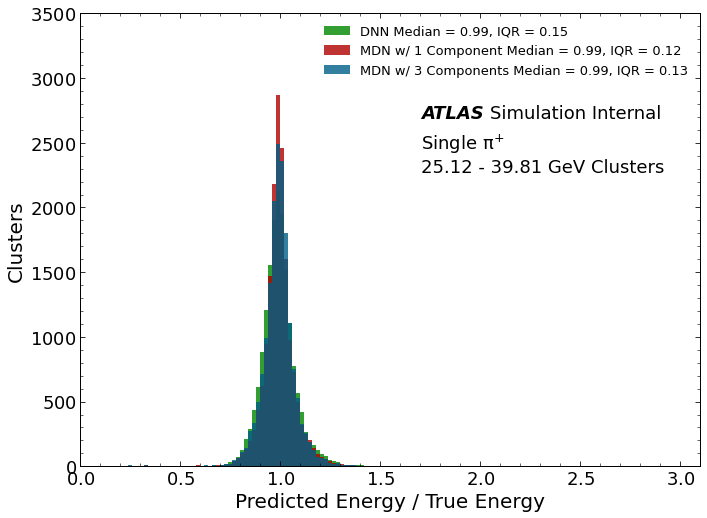

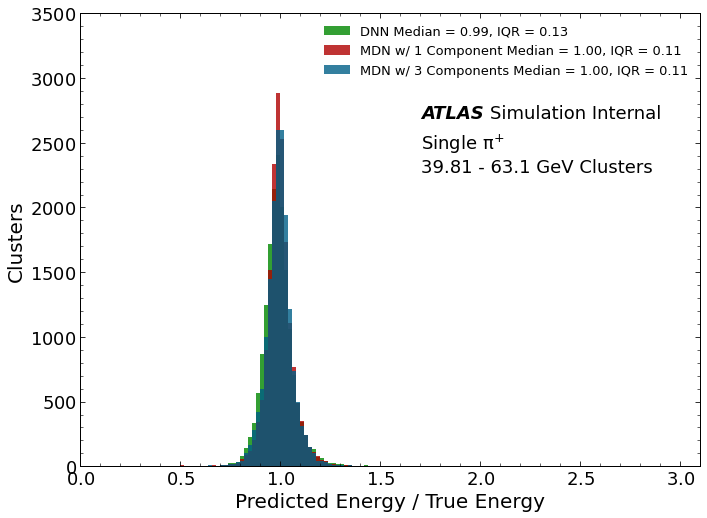

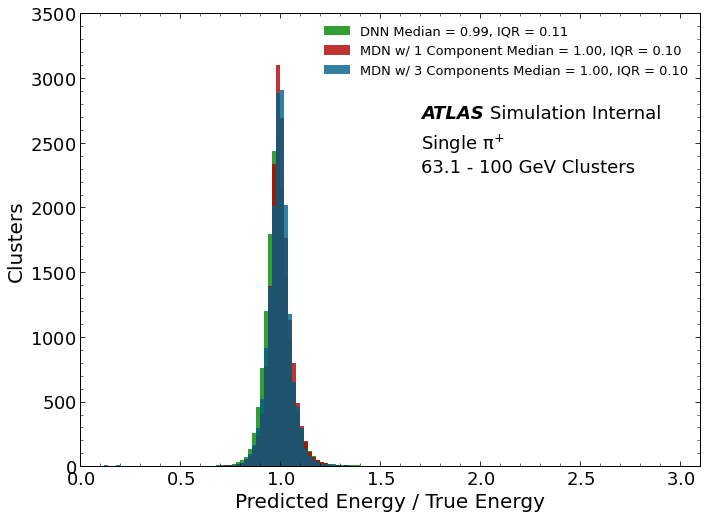

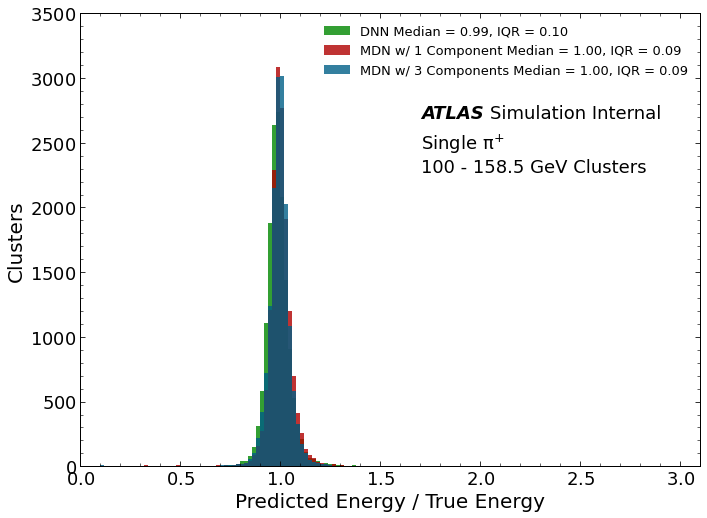

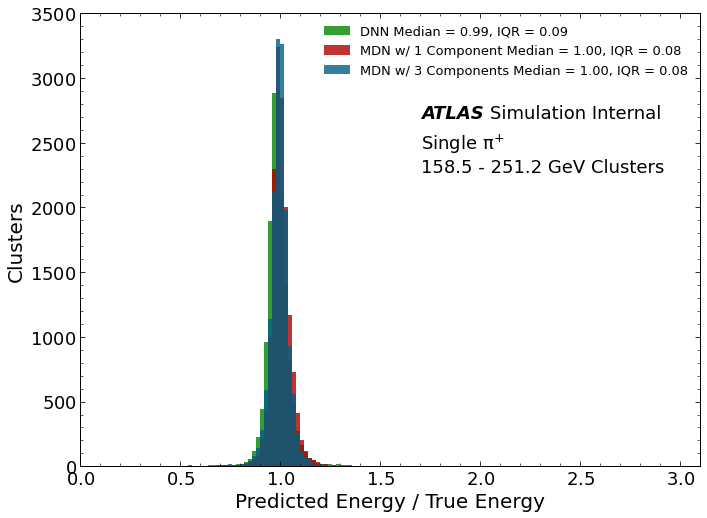

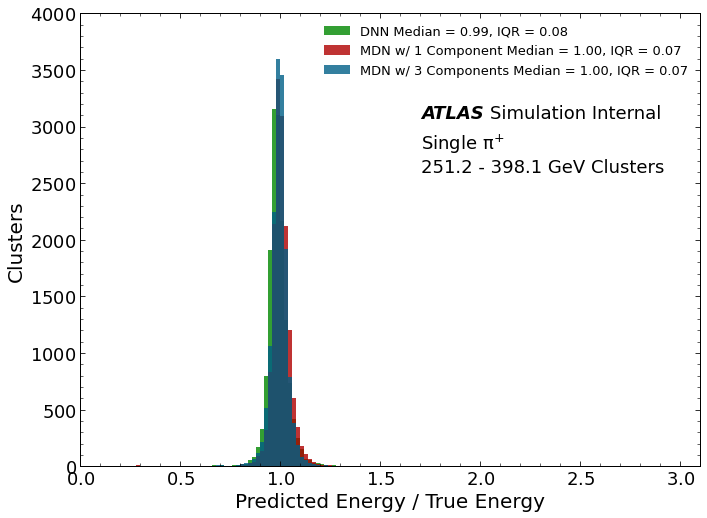

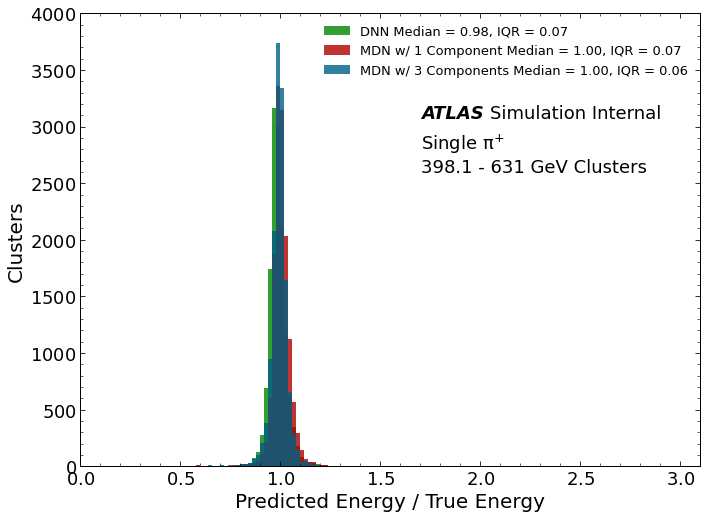

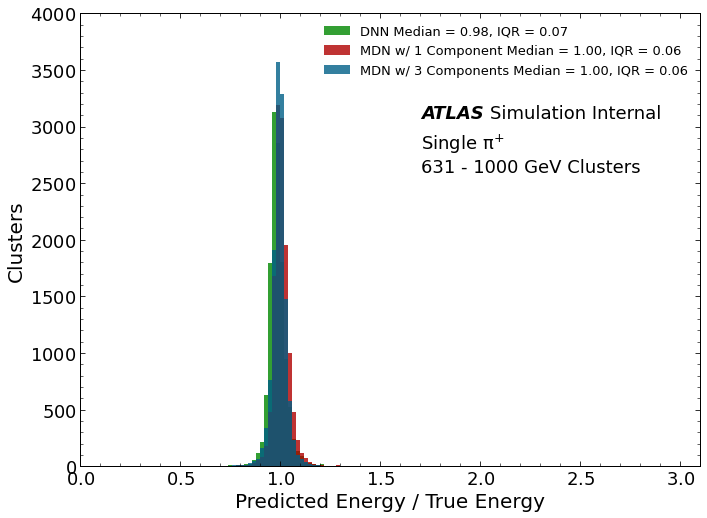

In [ ]:
histogramSlices(pp.cluster_ENG_CALIB_TOT, 
                ylist=[pp.predict_regressor_DNN_EoverCalib, 
                       pp.predict_regressor_MDN_EoverCalib, 
                       pp.predict_regressor_MDN3_EoverCalib],
                labels=['DNN', 'MDN w/ 1 Component', 'MDN w/ 3 Components'],
                binsize=0.02, xstep=0.2, alpha=0.8,
                atlas_x = 0.55, atlas_y = 0.8, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.7, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.65, 'text': ''}])

### Interquantile range

<Figure size 799.992x599.976 with 0 Axes>

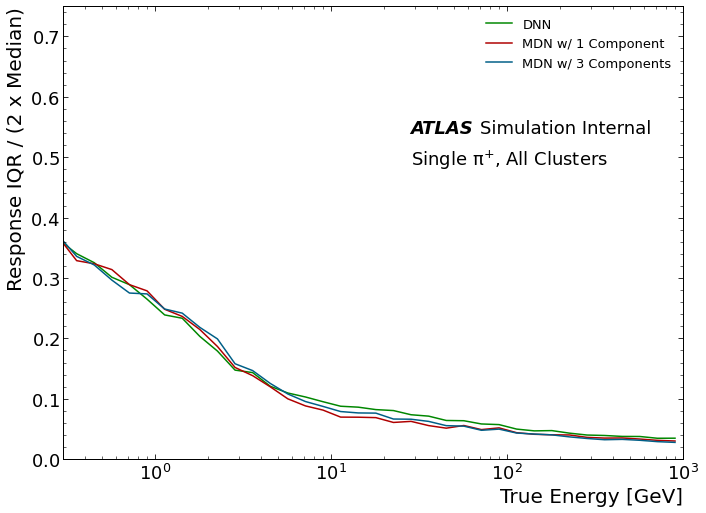

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrDNN, iqrMDN, iqrMDN3],
                labels = ['DNN', 'MDN w/ 1 Component', 'MDN w/ 3 Components'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Single $\pi^{+}$, All Clusters'}])

## Quantify per cluster uncertainty learned by MDN



#### Pull

In [ ]:
median = pred[:,0]
sigma = pred[:,1]

# Renormalize data (inverse transform scaler normalization); propogate uncertainties
median = scaler_cal.scale_ * median
sigma = scaler_cal.scale_ * sigma # or _median * (sigma / median)

median = median + scaler_cal.mean_

median = np.exp(median)   # Reconstructed Energy Per Cluster
sigma = median * sigma   # Reconstructed Energy Uncertainty (Std dev) Per Cluster


# Calculate pull
pull = (median-pp.cluster_ENG_CALIB_TOT) / sigma
badval_mask = np.logical_and(pull < 100, pull > -100)
pull = pull[badval_mask]

<Figure size 799.992x599.976 with 0 Axes>

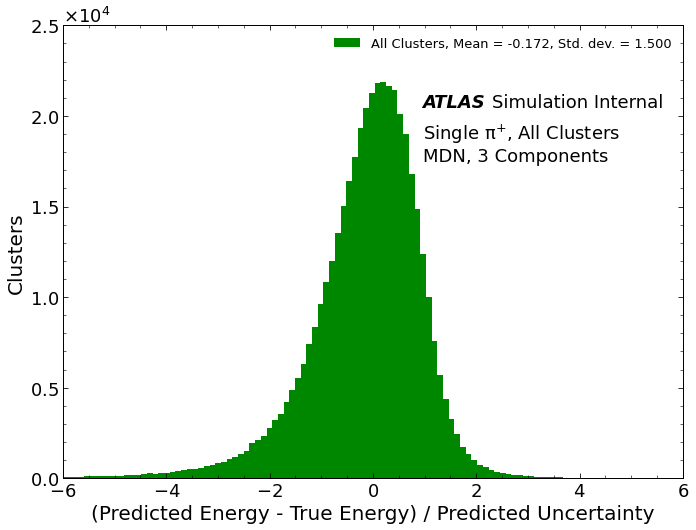

In [ ]:

# Plot pull
n_bins = 1000
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pull,bins = n_bins, label='All Clusters, Mean = {:.3f}, Std. dev. = {:.3f}'.format(pull.mean(), pull.std()))
plt.xlabel('(Predicted Energy - True Energy) / Predicted Uncertainty')
plt.ylabel('Clusters')
plt.xlim(-6,6)
plt.legend()

atlas_x = 0.58
atlas_y = 0.85
simulation = True
textlist = [{'x': 0.58, 'y': 0.75, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.58, 'y': 0.7, 'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

Number of values not in plotted range

In [ ]:
np.sum(np.logical_not(badval_mask))

29

<Figure size 799.992x599.976 with 0 Axes>

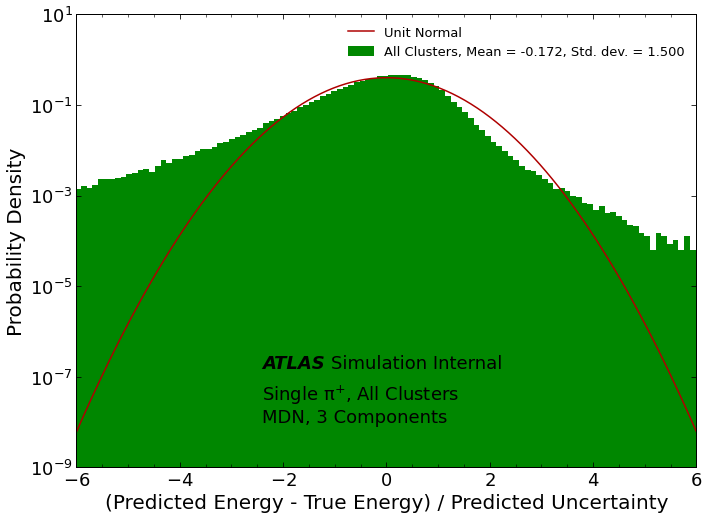

In [ ]:

# Plot pull
n_bins = 1000
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pull,bins = n_bins, density = True, label='All Clusters, Mean = {:.3f}, Std. dev. = {:.3f}'.format(pull.mean(), pull.std()))

x = np.linspace(-6,6,100)
pdf = stats.norm.pdf(x)
plt.plot(x, pdf, label='Unit Normal')

plt.xlabel('(Predicted Energy - True Energy) / Predicted Uncertainty')
plt.ylabel('Probability Density')
plt.xlim(-6,6)
plt.yscale('log')
plt.legend()

atlas_x = 0.3
atlas_y = 0.25
simulation = True
textlist = [{'x': 0.3, 'y': 0.15, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.3, 'y': 0.1, 'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

#### Pull Slices

<Figure size 799.992x599.976 with 0 Axes>

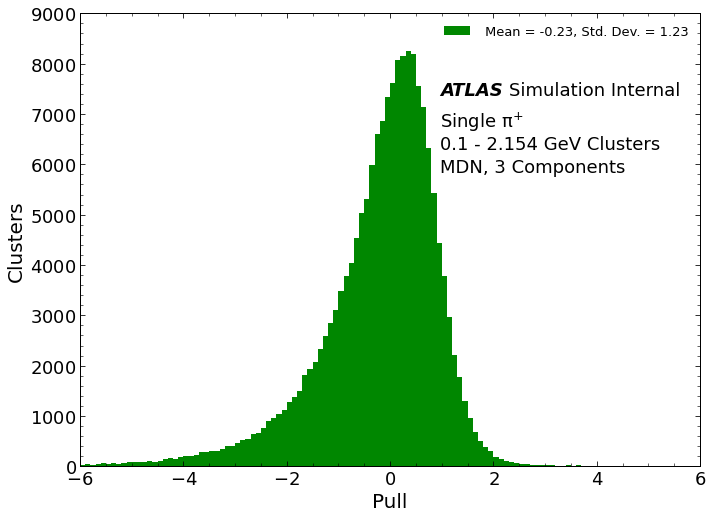

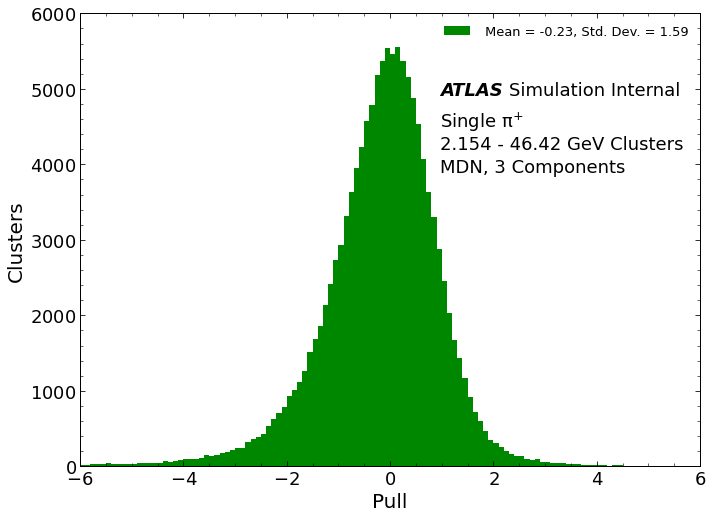

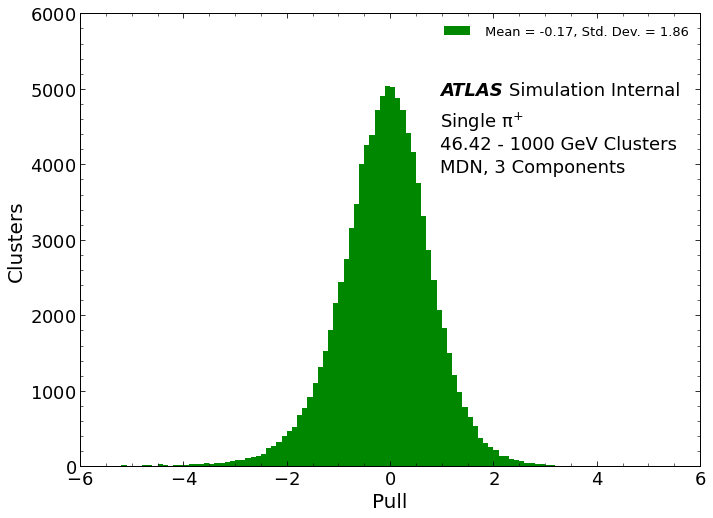

In [ ]:
histogramSlices(pp.cluster_ENG_CALIB_TOT, pull, statistic='std',
                ylim=(-6., 6.), xstep=1.3333333333333, binsize=0.1, 
                xlabel='Pull', ylabel='Clusters', title='Pull',
                atlas_x = 0.58, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.58, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.58, 'y': 0.7, 'text': ''},
                            {'x': 0.58, 'y': 0.65, 'text': 'MDN, 3 Components'}])

<Figure size 799.992x599.976 with 0 Axes>

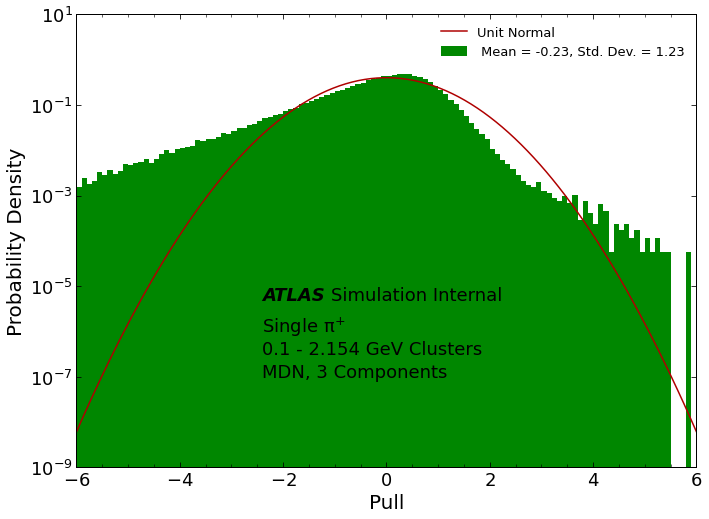

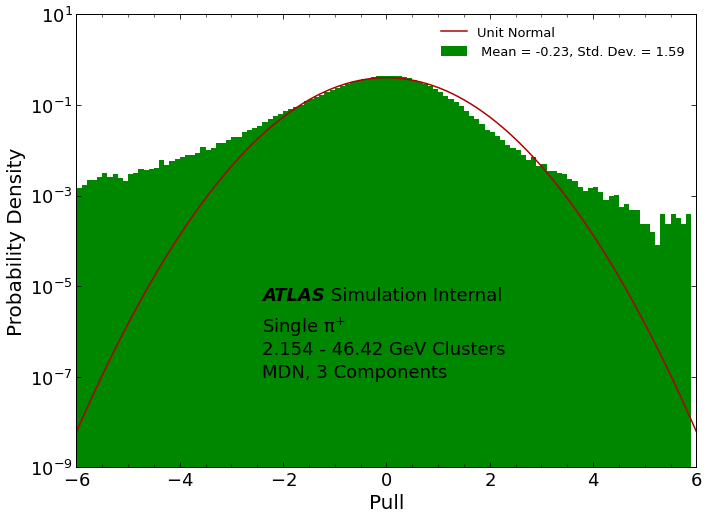

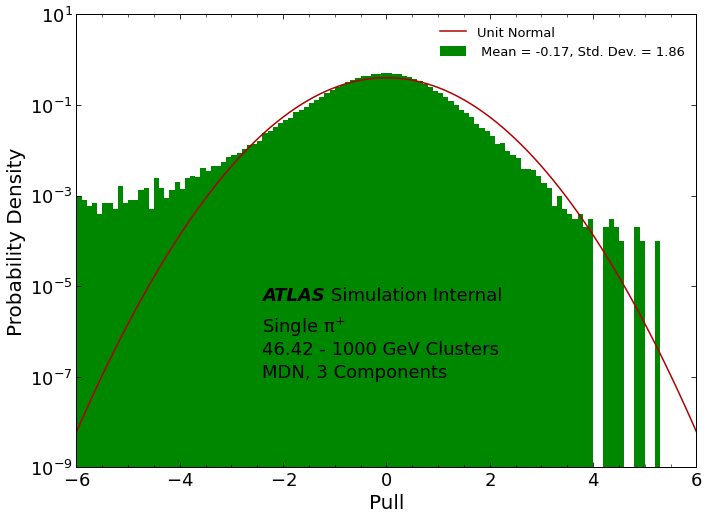

In [ ]:
histogramSlices(pp.cluster_ENG_CALIB_TOT, pull, statistic='std',
                ylim=(-6., 6.), xstep=1.3333333333333, binsize=0.1, baseline=True, logscale=True, density=True,
                xlabel='Pull', ylabel='Probability Density', title='Pull',
                atlas_x = 0.3, atlas_y = 0.4, simulation = True,
                textlist = [{'x': 0.3, 'y': 0.3, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.3, 'y': 0.25, 'text': ''},
                            {'x': 0.3, 'y': 0.2, 'text': 'MDN, 3 Components'}])

#### IQR

In [ ]:
median_over_true = median / pp.cluster_ENG_CALIB_TOT   #   Reconstructed Energy / True Energy
iqr_over_median = 2 * sigma / median  # Reconstructed Energy Resolution Per Cluster
iqr_over_true = 2 * sigma / pp.cluster_ENG_CALIB_TOT  # Pred Sigma / True Energy Per Cluster

<Figure size 799.992x599.976 with 0 Axes>

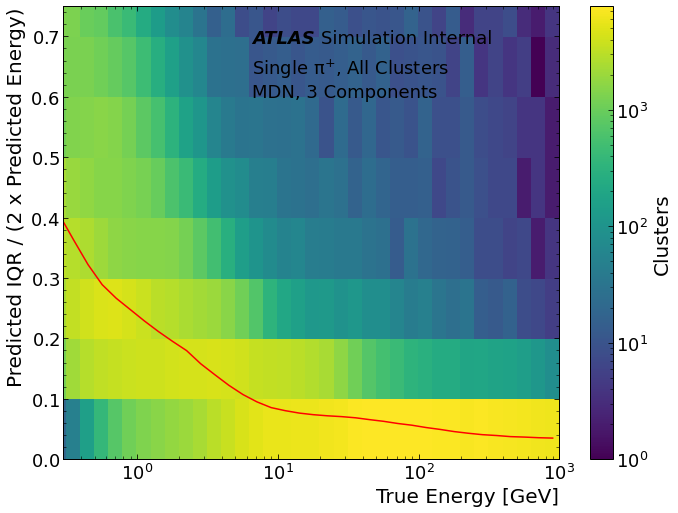

<Figure size 799.992x599.976 with 0 Axes>

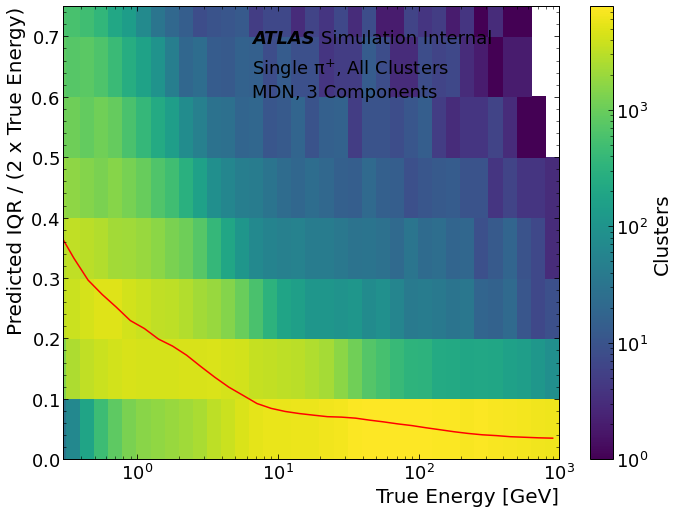

In [ ]:
xcenter, iqrOverMed_MDN_learned = ru.responsePlot(pp.cluster_ENG_CALIB_TOT, iqr_over_median/2,
                 plotpath+'hist_2D_calib_vs_sigma.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,0.75), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN, 3 Components'}])

xcenter, iqrOverTrue_MDN_learned = ru.responsePlot(pp.cluster_ENG_CALIB_TOT, iqr_over_true/2,
                 plotpath+'hist_2D_calib_vs_sigma.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,0.75), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x True Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN, 3 Components'}])

<Figure size 799.992x599.976 with 0 Axes>

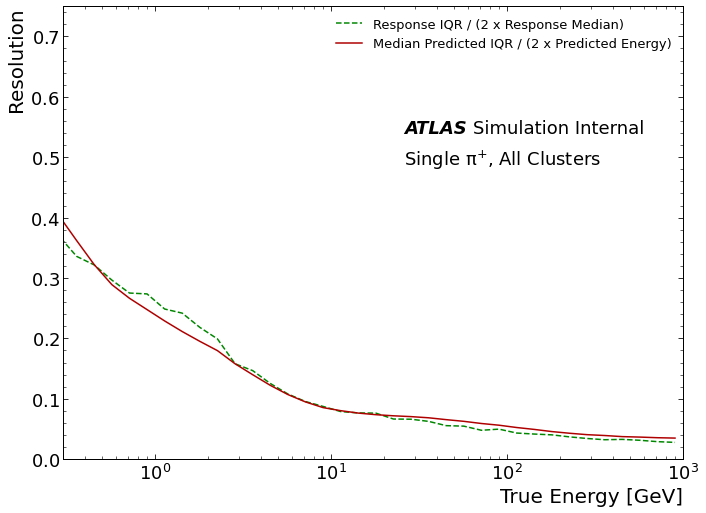

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrMDN3, iqrOverMed_MDN_learned],
                labels = ['Response IQR / (2 x Response Median)', 'Median Predicted IQR / (2 x Predicted Energy)'],
                xlabel = 'True Energy [GeV]', ylabel = 'Resolution',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = 0.75,
                linestyles = ['dashed', 'solid', 'solid'], colorgrouping=1,
                atlas_x = 0.55, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.65, 'text': 'Single $\pi^{+}$, All Clusters'}])

#### IQR Histogram Slices

In [ ]:
# histogramSlices(pp.cluster_ENG_CALIB_TOT, iqr_over_true, title='Response IQR')

# MDN Distribution Visualization (WIP)

In [ ]:
# Want to get pdf from X where X is a MixtureSameFamily object
# MixtureSameFamily doesn't have quantile() implemented

# This isn't working. Not returning vector of probabilities, only scalar vals
def convert_to_tensor(X):
    # return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)
    # return X.sample(100)
    return X.prob(np.linspace(-3,3,100))

def MDN3():
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
        
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, #validate_args=True,
                                           convert_to_tensor_fn=convert_to_tensor))

        opt = Adam(learning_rate=1e-4)#, decay=1e-6)
        model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

In [ ]:
regressor_All = MDN3()
regressor_All.load_weights(modelpath + 'mdn_regressor_2.h5')

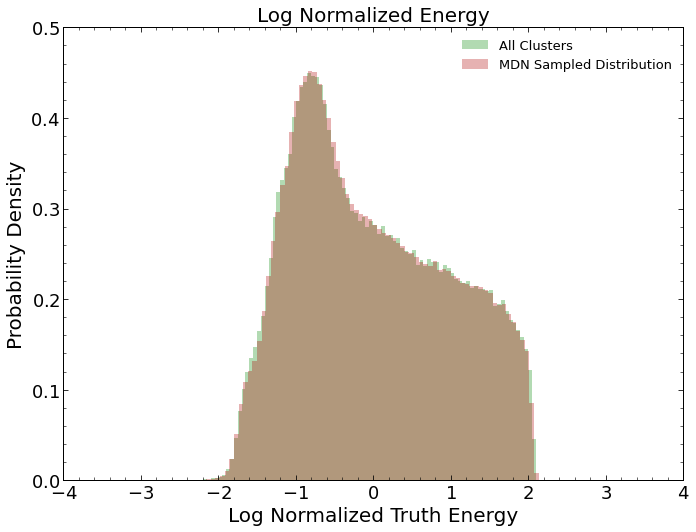

In [ ]:
test = regressor_All(All_input)

t1 = test.sample(10).numpy().reshape(-1)
t1 = t1[np.logical_and(t1 < 3, t1 > -3)]

plt.hist(pp[pp.train].s_logECalib.to_numpy(), bins=100, alpha=0.3, density=True, label='All Clusters')
plt.hist(t1, bins=100, alpha=0.3, density=True, label='MDN Sampled Distribution')
# plt.yscale('log')
plt.title("Log Normalized Energy")
plt.xlabel('Log Normalized Truth Energy')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

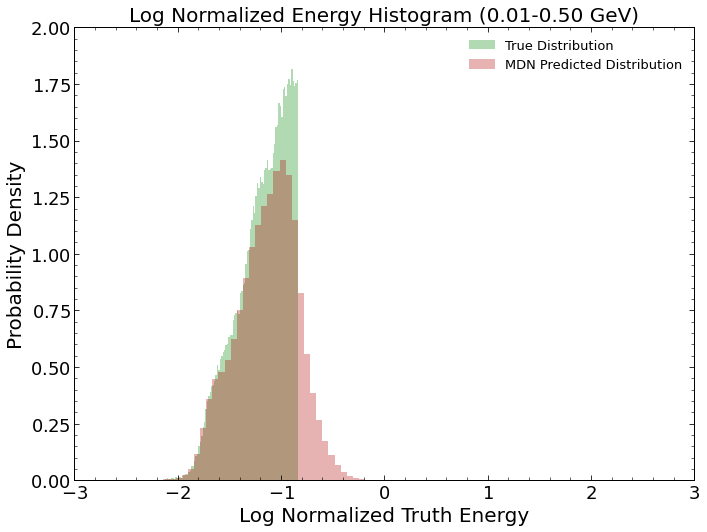

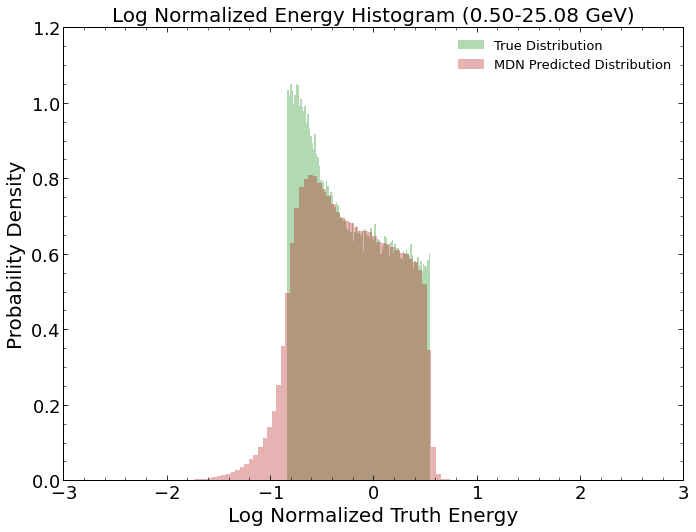

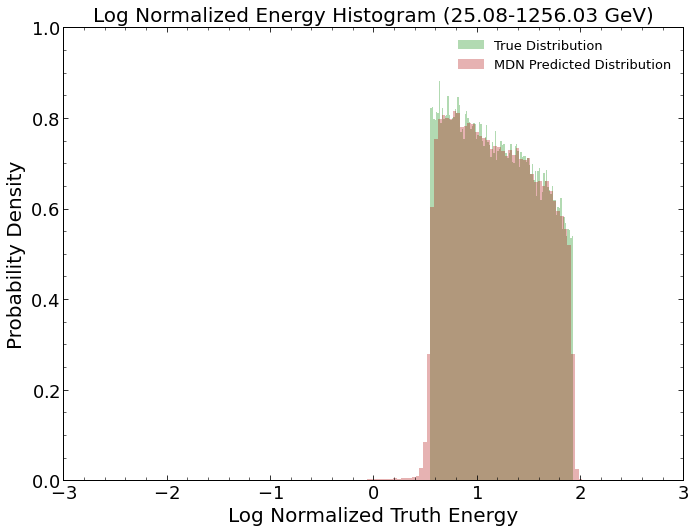

In [ ]:
energy_bins = [10**exp for exp in np.arange(-2.0, 3.1, 5.099/3.)]
for energy, last_energy in zip(energy_bins[1:], energy_bins[:-1]):
    energy_slice_mask = np.logical_and(pp.cluster_ENG_CALIB_TOT < energy, pp.cluster_ENG_CALIB_TOT > last_energy)
    test = regressor_All(All_input[energy_slice_mask])

    t1 = test.sample(10).numpy().reshape(-1)
    t1 = t1[np.logical_and(t1 < 3, t1 > -3)]

    plt.title("Log Normalized Energy Histogram ({:.2f}-{:.2f} GeV)".format(last_energy, energy))
    plt.hist(pp[energy_slice_mask].s_logECalib.to_numpy(), bins=100, alpha=0.3, density=True, label='True Distribution')
    plt.hist(t1, bins=100, alpha=0.3, density=True, label='MDN Predicted Distribution')
    plt.xlabel('Log Normalized Truth Energy')
    plt.ylabel('Probability Density')
    plt.xlim(-3,3)
    plt.legend()
    plt.show()

In [ ]:
test.quantile(0.5)

NotImplementedError: ignored